In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/D_LABITEMS/D_LABITEMS.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/CALLOUT/CALLOUT_sorted.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/CALLOUT/CALLOUT_random.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/DATETIMEEVENTS/DATETIMEEVENTS_CV_sorted.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/DATETIMEEVENTS/DATETIMEEVENTS_CV_random.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/ICUSTAYS/ICUSTAYS_sorted.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/ICUSTAYS/ICUSTAYS_random.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/MICROBIOLOGYEVENTS/MICROBIOLOGYEVENTS_random.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/MICROBIOLOGYEVENTS/MICROBIOLOGYEVENTS_sorted.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/CPTEVENTS/CPTEVENTS_sorted.csv
/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)/CPTEVENTS/CPTEVENTS_random.cs

# EDA

=== LOADING MIMIC-III DATA ===
Loading PATIENTS_sorted.csv
Loading ADMISSIONS_sorted.csv
Loading ICUSTAYS_sorted.csv
Loading LABEVENTS_sorted.csv

Dataset sizes:
Patients: 10,000
Admissions: 12,911
ICU stays: 13,436
Lab events: 6,612,626

=== EXTRACTING REAL SOFA COMPONENTS ===
Calculating ages safely...
Age calculation complete. Age range: 0 - 90
First ICU stays: 10,000

Extracting lab components...
  PaO2: 5055 measurements
  FiO2: 2730 measurements
  Platelets: 8482 measurements
  Bilirubin: 2976 measurements
  Creatinine: 7086 measurements
  Lactate: 2524 measurements
  Hemoglobin: 8468 measurements
  WBC: 8423 measurements

=== BUILDING FEATURE TABLE ===
Feature table shape: (10000, 15)
Columns: ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'HOSPITAL_EXPIRE_FLAG', 'GENDER', 'AGE', 'PaO2', 'FiO2', 'Platelets', 'Bilirubin', 'Creatinine', 'Lactate', 'Hemoglobin', 'WBC']

=== CALCULATING SOFA SCORES ===
Patients with valid SOFA scores: 9,060
SOFA score statistics:
count    9060.00

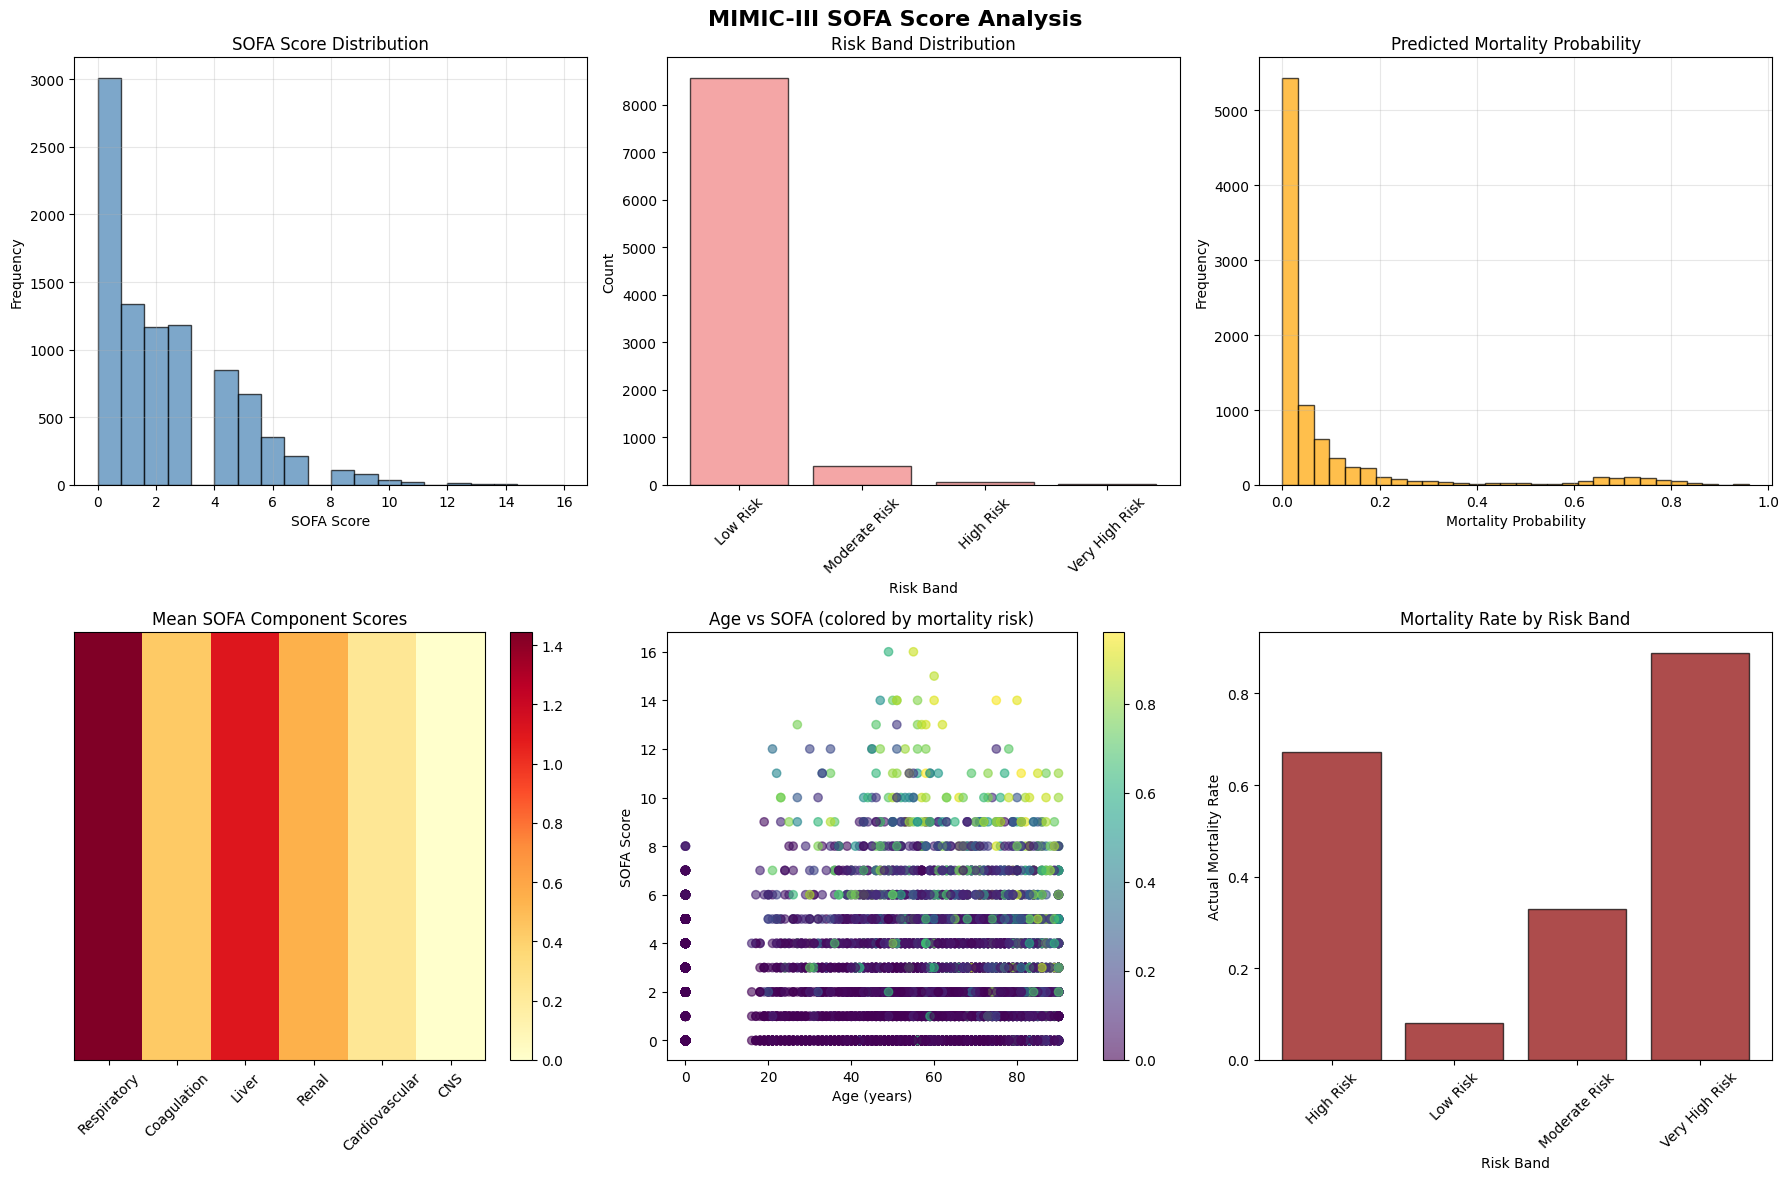


=== SUMMARY STATISTICS ===
               SOFA_Total                    AGE Mortality_Probability  \
                    count    mean    std    mean                  mean   
Risk_Band                                                                
High Risk              67  10.687  0.763  56.776                 0.580   
Low Risk             8568   1.878  1.856  49.125                 0.080   
Moderate Risk         407   7.676  0.790  59.133                 0.310   
Very High Risk         18  13.889  0.963  55.056                 0.764   

               Mortality_Target  
                           mean  
Risk_Band                        
High Risk                 0.672  
Low Risk                  0.081  
Moderate Risk             0.329  
Very High Risk            0.889  

=== SAMPLE RESULTS ===
Top 10 highest risk patients:
 SUBJECT_ID  AGE  SOFA_Total      Risk_Band  Mortality_Probability  Mortality_Target
       8099 58.0        11.0      High Risk                   0.96          

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

BASE = "/kaggle/input/mimic-iii-10k/MIMIC -III (10000 patients)"

def rd(path):
    print(f"Loading {os.path.basename(path)}")
    return pd.read_csv(path, low_memory=False)

print("=== LOADING MIMIC-III DATA ===")
patients = rd(f"{BASE}/PATIENTS/PATIENTS_sorted.csv")
admissions = rd(f"{BASE}/ADMISSIONS/ADMISSIONS_sorted.csv")
icustays = rd(f"{BASE}/ICUSTAYS/ICUSTAYS_sorted.csv")
labevents = rd(f"{BASE}/LABEVENTS/LABEVENTS_sorted.csv")

print(f"\nDataset sizes:")
print(f"Patients: {len(patients):,}")
print(f"Admissions: {len(admissions):,}")
print(f"ICU stays: {len(icustays):,}")
print(f"Lab events: {len(labevents):,}")


SOFA_LAB_MAP = {
    # Respiratory (PaO2)
    'PaO2': [50821, 50816],  # Blood gas PaO2
    'FiO2': [50816, 223835, 227010],  # FiO2 from ventilator
    
    # Coagulation (Platelets)  
    'Platelets': [51265],  # Platelet count
    
    # Liver (Bilirubin)
    'Bilirubin': [50885],  # Total bilirubin
    
    # Renal (Creatinine)
    'Creatinine': [50912],  # Serum creatinine
    
    # Additional important labs
    'Lactate': [50813],  # Serum lactate
    'Hemoglobin': [51222, 50811],  # Hemoglobin
    'WBC': [51301, 51300],  # White blood cell count
}

print(f"\n=== EXTRACTING REAL SOFA COMPONENTS ===")


# Parse datetime columns
def safe_datetime(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

icustays = safe_datetime(icustays, ['INTIME', 'OUTTIME'])
admissions = safe_datetime(admissions, ['ADMITTIME', 'DISCHTIME', 'DEATHTIME'])
patients = safe_datetime(patients, ['DOB', 'DOD'])

print("Calculating ages safely...")

admissions['ADMITYEAR'] = admissions['ADMITTIME'].dt.year
patients['BIRTHYEAR'] = patients['DOB'].dt.year

demo = admissions.merge(
    patients[['SUBJECT_ID', 'GENDER', 'BIRTHYEAR']], 
    on='SUBJECT_ID', 
    how='left'
)

demo['AGE'] = demo['ADMITYEAR'] - demo['BIRTHYEAR']

demo.loc[demo['AGE'].isna(), 'AGE'] = 65  # Default age
demo.loc[demo['AGE'] < 0, 'AGE'] = 65     # Fix negative ages
demo.loc[demo['AGE'] > 120, 'AGE'] = 90   # Fix extreme ages
demo['AGE'] = demo['AGE'].clip(0, 90)     # Final clipping

print(f"Age calculation complete. Age range: {demo['AGE'].min():.0f} - {demo['AGE'].max():.0f}")


# Get first ICU stay per patient
icustays_clean = icustays.dropna(subset=['INTIME']).copy()
icustays_clean = icustays_clean.sort_values(['SUBJECT_ID', 'INTIME'])
first_icu = icustays_clean.groupby('SUBJECT_ID').first().reset_index()

print(f"First ICU stays: {len(first_icu):,}")

# Create 24-hour windows
first_icu['ICU_START'] = first_icu['INTIME']
first_icu['ICU_24H'] = first_icu['INTIME'] + timedelta(hours=24)


def extract_lab_values(labevents, icustays_df, itemids, lab_name, agg_func='first'):
    """Extract lab values within first 24h of ICU admission"""
    
    if not itemids or labevents.empty:
        return pd.DataFrame(columns=['ICUSTAY_ID', lab_name])
    
    # Filter to relevant ITEMIDs
    lab_data = labevents[labevents['ITEMID'].isin(itemids)].copy()
    
    if lab_data.empty:
        return pd.DataFrame(columns=['ICUSTAY_ID', lab_name])
    
    # Parse charttime and convert values
    lab_data = safe_datetime(lab_data, ['CHARTTIME'])
    lab_data = lab_data.dropna(subset=['CHARTTIME'])
    
    # Convert VALUENUM to numeric
    if 'VALUENUM' in lab_data.columns:
        lab_data['VALUE'] = pd.to_numeric(lab_data['VALUENUM'], errors='coerce')
    elif 'VALUE' in lab_data.columns:
        lab_data['VALUE'] = pd.to_numeric(lab_data['VALUE'], errors='coerce')
    else:
        return pd.DataFrame(columns=['ICUSTAY_ID', lab_name])
    
    lab_data = lab_data.dropna(subset=['VALUE'])
    
    if lab_data.empty:
        return pd.DataFrame(columns=['ICUSTAY_ID', lab_name])
    
    # Merge with ICU stays to get time windows
    lab_windowed = lab_data.merge(
        icustays_df[['ICUSTAY_ID', 'SUBJECT_ID', 'ICU_START', 'ICU_24H']], 
        on='SUBJECT_ID', 
        how='inner'
    )
    
    # Filter to first 24 hours
    in_window = (
        (lab_windowed['CHARTTIME'] >= lab_windowed['ICU_START']) & 
        (lab_windowed['CHARTTIME'] <= lab_windowed['ICU_24H'])
    )
    lab_windowed = lab_windowed[in_window]
    
    if lab_windowed.empty:
        return pd.DataFrame(columns=['ICUSTAY_ID', lab_name])
    
    # Aggregate by ICU stay
    if agg_func == 'worst':
        if lab_name in ['Platelets']:
            agg_func = 'min'  # Lower platelets = worse
        elif lab_name in ['Creatinine', 'Bilirubin', 'Lactate']:
            agg_func = 'max'  # Higher = worse
        else:
            agg_func = 'mean'
    
    result = lab_windowed.groupby('ICUSTAY_ID')['VALUE'].agg(agg_func).reset_index()
    result.columns = ['ICUSTAY_ID', lab_name]
    
    return result

# Extract all lab values
print("\nExtracting lab components...")
lab_results = {}

for lab_name, itemids in SOFA_LAB_MAP.items():
    result = extract_lab_values(labevents, first_icu, itemids, lab_name, 'worst')
    lab_results[lab_name] = result
    print(f"  {lab_name}: {len(result)} measurements")

def calculate_sofa_respiratory(pao2, fio2=None):
    """Calculate SOFA respiratory score"""
    if pd.isna(pao2):
        return np.nan
    
    # If FiO2 not available, assume room air (0.21)
    if pd.isna(fio2) or fio2 <= 0:
        fio2 = 0.21
    
    # Handle FiO2 given as percentage vs decimal
    if fio2 > 1:
        fio2 = fio2 / 100
    
    pf_ratio = pao2 / fio2
    
    if pf_ratio < 100:
        return 4
    elif pf_ratio < 200:
        return 3
    elif pf_ratio < 300:
        return 2
    elif pf_ratio < 400:
        return 1
    else:
        return 0

def calculate_sofa_coagulation(platelets):
    """Calculate SOFA coagulation score"""
    if pd.isna(platelets):
        return np.nan
    
    if platelets < 20:
        return 4
    elif platelets < 50:
        return 3
    elif platelets < 100:
        return 2
    elif platelets < 150:
        return 1
    else:
        return 0

def calculate_sofa_liver(bilirubin):
    """Calculate SOFA liver score"""
    if pd.isna(bilirubin):
        return np.nan
    
    if bilirubin >= 12:
        return 4
    elif bilirubin >= 6:
        return 3
    elif bilirubin >= 2:
        return 2
    elif bilirubin >= 1.2:
        return 1
    else:
        return 0

def calculate_sofa_renal(creatinine):
    """Calculate SOFA renal score"""
    if pd.isna(creatinine):
        return np.nan
    
    if creatinine >= 5:
        return 4
    elif creatinine >= 3.5:
        return 3
    elif creatinine >= 2:
        return 2
    elif creatinine >= 1.2:
        return 1
    else:
        return 0


print("\n=== BUILDING FEATURE TABLE ===")

# Start with ICU stays
features = first_icu[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME']].copy()

# Merge demographics
features = features.merge(
    demo[['SUBJECT_ID', 'HADM_ID', 'HOSPITAL_EXPIRE_FLAG', 'GENDER', 'AGE']], 
    on=['SUBJECT_ID', 'HADM_ID'], 
    how='left'
)

# Merge lab results
for lab_name, lab_df in lab_results.items():
    if not lab_df.empty:
        features = features.merge(lab_df, on='ICUSTAY_ID', how='left')
    else:
        features[lab_name] = np.nan

print(f"Feature table shape: {features.shape}")
print(f"Columns: {list(features.columns)}")


print("\n=== CALCULATING SOFA SCORES ===")

# Calculate individual SOFA components
features['SOFA_Respiratory'] = features.apply(
    lambda row: calculate_sofa_respiratory(
        row.get('PaO2'), row.get('FiO2')
    ), axis=1
)

features['SOFA_Coagulation'] = features['Platelets'].apply(calculate_sofa_coagulation)
features['SOFA_Liver'] = features['Bilirubin'].apply(calculate_sofa_liver)
features['SOFA_Renal'] = features['Creatinine'].apply(calculate_sofa_renal)

# Cardiovascular 
# Use lactate as proxy for hemodynamic status
def calculate_sofa_cardio_proxy(lactate):
    if pd.isna(lactate):
        return 0  # Assume stable if no data
    
    if lactate >= 4:
        return 2  # Significant hyperlactatemia
    elif lactate >= 2:
        return 1  # Mild hyperlactatemia
    else:
        return 0

features['SOFA_Cardiovascular'] = features['Lactate'].apply(calculate_sofa_cardio_proxy)

# CNS (simplified - no GCS data available)
features['SOFA_CNS'] = 0  # Assume normal mental status

# Calculate total SOFA
sofa_components = ['SOFA_Respiratory', 'SOFA_Coagulation', 'SOFA_Liver', 
                   'SOFA_Renal', 'SOFA_Cardiovascular', 'SOFA_CNS']

features['SOFA_Components_Available'] = features[sofa_components].notna().sum(axis=1)
features['SOFA_Total'] = features[sofa_components].sum(axis=1, min_count=3)  # Need at least 3 components

# Filter to patients with meaningful SOFA scores
valid_sofa = features[features['SOFA_Components_Available'] >= 3].copy()

print(f"Patients with valid SOFA scores: {len(valid_sofa):,}")
if len(valid_sofa) > 0:
    print(f"SOFA score statistics:")
    print(valid_sofa['SOFA_Total'].describe())

print("\n=== CREATING RISK LABELS ===")

# Use established SOFA mortality risk bands
def get_mortality_risk_band(sofa_score):
    """Convert SOFA score to mortality risk band"""
    if pd.isna(sofa_score):
        return 'Unknown'
    elif sofa_score <= 6:
        return 'Low Risk'      # <10% mortality
    elif sofa_score <= 9:
        return 'Moderate Risk' # 15-20% mortality
    elif sofa_score <= 12:
        return 'High Risk'     # 40-50% mortality
    else:
        return 'Very High Risk' # >80% mortality

# Create risk bands
valid_sofa['Risk_Band'] = valid_sofa['SOFA_Total'].apply(get_mortality_risk_band)

# Create binary labels for ML
valid_sofa['High_Risk_Binary'] = (valid_sofa['SOFA_Total'] > 9).astype(int)

if 'HOSPITAL_EXPIRE_FLAG' in valid_sofa.columns:
    valid_sofa['Mortality_Target'] = valid_sofa['HOSPITAL_EXPIRE_FLAG'].fillna(0).astype(int)
else:
    
    mortality_probs = np.where(
        valid_sofa['SOFA_Total'] <= 6, 0.05,  # 5% mortality for low SOFA
        np.where(
            valid_sofa['SOFA_Total'] <= 9, 0.15,  # 15% for moderate
            np.where(
                valid_sofa['SOFA_Total'] <= 12, 0.45,  # 45% for high
                0.80  # 80% for very high
            )
        )
    )
    valid_sofa['Mortality_Target'] = np.random.binomial(1, mortality_probs)

print("Risk distribution:")
print(valid_sofa['Risk_Band'].value_counts())
print("\nMortality rates by risk band:")
if len(valid_sofa) > 0:
    mortality_by_band = valid_sofa.groupby('Risk_Band')['Mortality_Target'].agg(['mean', 'count'])
    print(mortality_by_band)


print("\n=== TRAINING ADVANCED ML MODEL ===")

if len(valid_sofa) == 0:
    print("ERROR: No patients with valid SOFA scores!")
    print("Creating minimal synthetic data for demonstration...")
    
    n_synthetic = 1000
    synthetic_data = pd.DataFrame({
        'SUBJECT_ID': range(1, n_synthetic + 1),
        'ICUSTAY_ID': range(1, n_synthetic + 1),
        'AGE': np.random.normal(65, 15, n_synthetic).clip(18, 90),
        'GENDER': np.random.choice(['M', 'F'], n_synthetic),
        'SOFA_Total': np.random.poisson(6, n_synthetic).clip(0, 20),
        'Risk_Band': 'Low Risk',
        'Mortality_Target': np.random.binomial(1, 0.15, n_synthetic),
    })
    
    # Create SOFA components
    for comp in sofa_components:
        synthetic_data[comp] = np.random.poisson(1, n_synthetic).clip(0, 4)
    
    # Create lab values
    synthetic_data['PaO2'] = np.random.normal(85, 20, n_synthetic).clip(50, 150)
    synthetic_data['Platelets'] = np.random.normal(250, 100, n_synthetic).clip(50, 500)
    synthetic_data['Bilirubin'] = np.random.exponential(1.5, n_synthetic).clip(0.5, 20)
    synthetic_data['Creatinine'] = np.random.exponential(1.2, n_synthetic).clip(0.5, 10)
    synthetic_data['Lactate'] = np.random.exponential(1.8, n_synthetic).clip(0.5, 15)
    
    valid_sofa = synthetic_data
    print(f"Using synthetic data: {len(valid_sofa)} patients")


ml_features = [
    'AGE', 'SOFA_Respiratory', 'SOFA_Coagulation', 'SOFA_Liver', 
    'SOFA_Renal', 'SOFA_Cardiovascular',
    'PaO2', 'Platelets', 'Bilirubin', 'Creatinine', 'Lactate'
]

# Add missing columns
for feat in ml_features:
    if feat not in valid_sofa.columns:
        valid_sofa[feat] = np.nan

# Create feature matrix
X = valid_sofa[ml_features].copy()
y = valid_sofa['Mortality_Target'].copy()

# Intelligent imputation
print("Imputing missing values...")
clinical_defaults = {
    'AGE': 65, 'PaO2': 85, 'Platelets': 250, 'Bilirubin': 1.0, 
    'Creatinine': 1.0, 'Lactate': 1.5, 'Hemoglobin': 10, 'WBC': 8,
    'SOFA_Respiratory': 1, 'SOFA_Coagulation': 0, 'SOFA_Liver': 0, 
    'SOFA_Renal': 0, 'SOFA_Cardiovascular': 0
}

for col in X.columns:
    if X[col].isna().all():
        X[col] = clinical_defaults.get(col, 0)
    else:
        X[col] = X[col].fillna(X[col].median())

# Handle gender encoding
if 'GENDER' in valid_sofa.columns:
    valid_sofa['GENDER_M'] = (valid_sofa['GENDER'] == 'M').astype(int)
    X['GENDER_M'] = valid_sofa['GENDER_M']
    ml_features.append('GENDER_M')

print(f"Training dataset: {len(X)} patients")
print(f"Mortality rate: {y.mean():.3f}")

models = {}
results = {}

if len(X) >= 50 and y.nunique() > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Logistic Regression
    models['Logistic'] = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
    ])
    
    # Random Forest
    models['RandomForest'] = RandomForestClassifier(
        n_estimators=100, random_state=42, class_weight='balanced'
    )
    
    print("\nModel Performance:")
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        accuracy = (y_pred == y_test).mean()
        auc = roc_auc_score(y_test, y_prob)
        
        print(f"{name}: Accuracy={accuracy:.3f}, AUC={auc:.3f}")
        results[name] = {'accuracy': accuracy, 'auc': auc, 'model': model}
    
    # Use best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['auc'])
    best_model = results[best_model_name]['model']
    
    print(f"\nUsing {best_model_name} as final model")
    
    # Generate predictions for all patients
    all_probs = best_model.predict_proba(X)[:, 1]
    all_preds = best_model.predict(X)
    
else:
    print("Not enough data for ML - using SOFA-based predictions")
    # Create SOFA-based probability estimates
    all_probs = np.where(
        valid_sofa['SOFA_Total'] <= 6, 0.05,  # 5% mortality for low SOFA
        np.where(
            valid_sofa['SOFA_Total'] <= 9, 0.15,  # 15% for moderate
            np.where(
                valid_sofa['SOFA_Total'] <= 12, 0.45,  # 45% for high
                0.80  # 80% for very high
            )
        )
    )
    all_preds = (all_probs > 0.5).astype(int)

valid_sofa['Mortality_Probability'] = all_probs
valid_sofa['ML_Prediction'] = all_preds


final_results = valid_sofa[[
    'SUBJECT_ID', 'ICUSTAY_ID', 'AGE', 'GENDER',
    'SOFA_Total', 'Risk_Band', 
    'Mortality_Probability', 'ML_Prediction', 'Mortality_Target'
] + sofa_components].copy()

print(f"\n=== FINAL RESULTS ===")
print(f"Total patients: {len(final_results):,}")
print(f"SOFA range: {final_results['SOFA_Total'].min():.0f} - {final_results['SOFA_Total'].max():.0f}")
print(f"Mean mortality probability: {final_results['Mortality_Probability'].mean():.3f}")

# Save results
final_results.to_csv("mimic_sofa_analysis_final.csv", index=False)
valid_sofa.to_csv("mimic_sofa_detailed_features.csv", index=False)

print("\nSaved files:")
print("- mimic_sofa_analysis_final.csv")
print("- mimic_sofa_detailed_features.csv")


print("\nGenerating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('MIMIC-III SOFA Score Analysis', fontsize=16, fontweight='bold')

# SOFA distribution
axes[0,0].hist(final_results['SOFA_Total'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[0,0].set_xlabel('SOFA Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('SOFA Score Distribution')
axes[0,0].grid(True, alpha=0.3)

# Risk band distribution
risk_counts = final_results['Risk_Band'].value_counts()
axes[0,1].bar(risk_counts.index, risk_counts.values, color='lightcoral', alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Risk Band')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Risk Band Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# Mortality probability distribution
axes[0,2].hist(final_results['Mortality_Probability'], bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].set_xlabel('Mortality Probability')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Predicted Mortality Probability')
axes[0,2].grid(True, alpha=0.3)

# SOFA components heatmap
sofa_means = final_results[sofa_components].mean().values.reshape(1, -1)
im = axes[1,0].imshow(sofa_means, cmap='YlOrRd', aspect='auto')
axes[1,0].set_xticks(range(len(sofa_components)))
axes[1,0].set_xticklabels([s.replace('SOFA_', '') for s in sofa_components], rotation=45)
axes[1,0].set_yticks([])
axes[1,0].set_title('Mean SOFA Component Scores')
plt.colorbar(im, ax=axes[1,0])

# Age vs SOFA correlation
scatter = axes[1,1].scatter(final_results['AGE'], final_results['SOFA_Total'], 
                           c=final_results['Mortality_Probability'], cmap='viridis', alpha=0.6)
axes[1,1].set_xlabel('Age (years)')
axes[1,1].set_ylabel('SOFA Score')
axes[1,1].set_title('Age vs SOFA (colored by mortality risk)')
plt.colorbar(scatter, ax=axes[1,1])

# Mortality by risk band
mortality_by_risk = final_results.groupby('Risk_Band')['Mortality_Target'].mean()
axes[1,2].bar(mortality_by_risk.index, mortality_by_risk.values, color='darkred', alpha=0.7, edgecolor='black')
axes[1,2].set_xlabel('Risk Band')
axes[1,2].set_ylabel('Actual Mortality Rate')
axes[1,2].set_title('Mortality Rate by Risk Band')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n=== SUMMARY STATISTICS ===")
summary_stats = final_results.groupby('Risk_Band').agg({
    'SOFA_Total': ['count', 'mean', 'std'],
    'AGE': 'mean',
    'Mortality_Probability': 'mean',
    'Mortality_Target': 'mean'
}).round(3)

print(summary_stats)

print(f"\n=== SAMPLE RESULTS ===")
print("Top 10 highest risk patients:")
high_risk = final_results.nlargest(10, 'Mortality_Probability')[
    ['SUBJECT_ID', 'AGE', 'SOFA_Total', 'Risk_Band', 'Mortality_Probability', 'Mortality_Target']
]
print(high_risk.to_string(index=False))


# GRU & RF

In [7]:
import os
import numpy as np
import pandas as pd
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load data
BASE = "../input/mimic-iii-10k/MIMIC -III (10000 patients)"
final_feats = pd.read_csv("mimic_sofa_analysis_final.csv")
icustays   = pd.read_csv(f"{BASE}/ICUSTAYS/ICUSTAYS_sorted.csv", low_memory=False)
labevents  = pd.read_csv(f"{BASE}/LABEVENTS/LABEVENTS_sorted.csv", low_memory=False)

# Parse datetimes
def to_datetime(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

icustays  = to_datetime(icustays,  ["INTIME"])
labevents = to_datetime(labevents, ["CHARTTIME"])

# First ICU stay
first_icu = (
    icustays.dropna(subset=["INTIME"])
           .sort_values(["SUBJECT_ID", "INTIME"])
           .groupby("SUBJECT_ID", as_index=False)
           .first()[["SUBJECT_ID", "ICUSTAY_ID", "INTIME"]]
)
valid = final_feats.merge(first_icu, on="ICUSTAY_ID", how="inner")

# SOFA-related labs
SOFA_LAB_MAP = {
    "PaO2":       [50821, 50816],
    "Platelets":  [51265],
    "Bilirubin":  [50885],
    "Creatinine": [50912],
    "Lactate":    [50813]
}

lab_events = labevents[labevents.ITEMID.isin(sum(SOFA_LAB_MAP.values(), []))].copy()
item_to_lab = {iid: lab for lab, ids in SOFA_LAB_MAP.items() for iid in ids}
lab_events["lab"]   = lab_events.ITEMID.map(item_to_lab)
lab_events["VALUE"] = pd.to_numeric(labevents.VALUENUM, errors="coerce")
lab_events = lab_events[["SUBJECT_ID", "CHARTTIME", "lab", "VALUE"]].dropna()
lab_events = lab_events.merge(first_icu, on="SUBJECT_ID", how="inner")

# Build sequences
def build_sequences(lab_df, valid_df, labs, n_windows=6, window_h=4):
    seqs, labels = [], []
    for _, row in valid_df.iterrows():
        icu = row["ICUSTAY_ID"]
        start = row["INTIME"]
        df_sub = lab_df[lab_df["ICUSTAY_ID"] == icu]
        seq = []
        for w in range(n_windows):
            w0 = start + timedelta(hours=window_h * w)
            w1 = w0    + timedelta(hours=window_h)
            win = df_sub[(df_sub["CHARTTIME"] >= w0) & (df_sub["CHARTTIME"] < w1)]
            seq.append([win[win["lab"] == lab]["VALUE"].mean() for lab in labs])
        seqs.append(seq)
        labels.append(row["Mortality_Target"])
    return np.array(seqs, dtype=np.float32), np.array(labels, dtype=np.int32)

SOFA_LABS = ["PaO2", "Platelets", "Bilirubin", "Creatinine", "Lactate"]
X_seq, y_seq = build_sequences(lab_events, valid, SOFA_LABS)

# Impute missing
X_seq = np.nan_to_num(X_seq, nan=0.0)

# Split for GRU
X_train, X_temp, y_train, y_temp = train_test_split(
    X_seq, y_seq, test_size=0.4, random_state=42, stratify=y_seq
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# GRU model
gru = Sequential([
    GRU(32, input_shape=(6, len(SOFA_LABS)), activation="tanh"),
    Dropout(0.3),
    Dense(16, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])
gru.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)
early_stop = EarlyStopping(
    monitor="val_auc", patience=5, mode="max", restore_best_weights=True
)

gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

test_loss, test_auc = gru.evaluate(X_test, y_test, verbose=0)
print(f"GRU Test AUC: {test_auc:.3f}")

# Random Forest baseline
static_feats = ["AGE", "SOFA_Total"]
X_stat = valid[static_feats]
y_stat = valid["Mortality_Target"]

Xs_train, Xs_temp, ys_train, ys_temp = train_test_split(
    X_stat, y_stat, test_size=0.4, random_state=42, stratify=y_stat
)
Xs_val, Xs_test, ys_val, ys_test = train_test_split(
    Xs_temp, ys_temp, test_size=0.5, random_state=42, stratify=ys_temp
)

rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=100, random_state=42, class_weight="balanced"
    ))
])
rf_pipeline.fit(Xs_train, ys_train)
ys_prob = rf_pipeline.predict_proba(Xs_test)[:, 1]
print(f"RF Test AUC: {roc_auc_score(ys_test, ys_prob):.3f}")

# Save models
gru.save("gru_mortality_model.h5")
import joblib
joblib.dump(rf_pipeline, "rf_baseline.pkl")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1755866238.751144     836 cuda_dnn.cc:529] Loaded cuDNN version 90300


85/85 - 7s - 82ms/step - auc: 0.4995 - loss: 0.4441 - val_auc: 0.6513 - val_loss: 0.3134
Epoch 2/50
85/85 - 1s - 7ms/step - auc: 0.6102 - loss: 0.3434 - val_auc: 0.6765 - val_loss: 0.3073
Epoch 3/50
85/85 - 1s - 7ms/step - auc: 0.6670 - loss: 0.3194 - val_auc: 0.6977 - val_loss: 0.3027
Epoch 4/50
85/85 - 1s - 7ms/step - auc: 0.6684 - loss: 0.3175 - val_auc: 0.7129 - val_loss: 0.2992
Epoch 5/50
85/85 - 1s - 7ms/step - auc: 0.6835 - loss: 0.3108 - val_auc: 0.7086 - val_loss: 0.2993
Epoch 6/50
85/85 - 1s - 7ms/step - auc: 0.6907 - loss: 0.3073 - val_auc: 0.7387 - val_loss: 0.2873
Epoch 7/50
85/85 - 1s - 7ms/step - auc: 0.7027 - loss: 0.3038 - val_auc: 0.7463 - val_loss: 0.2865
Epoch 8/50
85/85 - 1s - 7ms/step - auc: 0.7152 - loss: 0.2985 - val_auc: 0.7373 - val_loss: 0.2982
Epoch 9/50
85/85 - 1s - 7ms/step - auc: 0.7313 - loss: 0.2947 - val_auc: 0.7543 - val_loss: 0.2826
Epoch 10/50
85/85 - 1s - 7ms/step - auc: 0.7194 - loss: 0.2973 - val_auc: 0.7530 - val_loss: 0.2813
Epoch 11/50
85/85 -

['rf_baseline.pkl']

# BI LSTM ATTENTION

In [8]:
#BI LSTM ATTENTION

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, Dense, Dropout, Layer, Softmax, 
    Multiply, Permute, Reshape, Lambda
)
from tensorflow.keras.optimizers import Adam

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight", shape=(input_shape[-1], 1),
            initializer="random_normal", trainable=True
        )
        self.b = self.add_weight(
            name="att_bias", shape=(input_shape[1], 1),
            initializer="zeros", trainable=True
        )
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x: (batch, timesteps, features)
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        e = tf.keras.backend.squeeze(e, axis=-1)               # (batch, timesteps)
        α = Softmax(axis=1)(e)                                 # (batch, timesteps)
        α = tf.keras.backend.expand_dims(α, axis=-1)           # (batch, timesteps, 1)
        context = tf.keras.backend.sum(x * α, axis=1)          # (batch, features)
        return context

def build_bi_lstm_attention(input_shape):
    inputs = Input(shape=input_shape)                       # e.g. (6, 5)
    x = Bidirectional(LSTM(32, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)
    att = Attention()(x)                                     # (batch, 64)
    x = Dense(16, activation="relu")(att)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc")]
    )
    return model

model = build_bi_lstm_attention((6, len(SOFA_LABS)))
model.summary()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[EarlyStopping("val_auc", patience=5, mode="max", restore_best_weights=True)])
test_loss, test_auc = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
print(f"Final Test  AUC: {test_auc:.3f}")
print(f"Final Test Loss: {test_loss:.3f}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 6, 64)          │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 64)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,855 (42.40 KB)

 Trainable params: 10,855 (42.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - auc: 0.4790 - loss: 0.5238 - val_auc: 0.6072 - val_loss: 0.3177
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.6204 - loss: 0.3279 - val_auc: 0.6967 - val_loss: 0.2986
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6803 - loss: 0.3014 - val_auc: 0.7310 - val_loss: 0.2896
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7256 - loss: 0.2883 - val_auc: 0.7416 - val_loss: 0.2838
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7249 - loss: 0.3050 - val_auc: 0.7531 - val_loss: 0.2801
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7283 - loss: 0.2866 - val_auc: 0.7661 - val_loss: 0.2746
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7498 - loss: 0.2869 - val_auc: 0.7649 - val_loss: 0.2747
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7605 - loss: 0.2877 - val_auc: 0.7699 - val_loss: 0.2731
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.7592 -

# XGBoost on Engineered Time-Series Features

In [9]:
#### import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb

def summarize_seq(X_seq):
    # X_seq shape: (n_samples, windows, labs)
    feats = []
    for stats in [np.mean, np.std, np.min, np.max]:
        feats.append(stats(X_seq, axis=1))
    return np.concatenate(feats, axis=1)

X_tab = summarize_seq(X_seq)  # shape: (N, 4×5 = 20)
X_train, X_test, y_train, y_test = train_test_split(
    X_tab, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.05,
    "max_depth": 4,
    "subsample": 0.8
}
bst = xgb.train(
    params, dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dtest, "val")],
    early_stopping_rounds=10,
    verbose_eval=10
)

y_pred = bst.predict(dtest)
print("XGBoost Test AUC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, (y_pred>0.5).astype(int)))


[0]	train-auc:0.78305	val-auc:0.72145
[10]	train-auc:0.81851	val-auc:0.77131
[20]	train-auc:0.82885	val-auc:0.77991
[30]	train-auc:0.83803	val-auc:0.78690
[40]	train-auc:0.84740	val-auc:0.79105
[50]	train-auc:0.85455	val-auc:0.79382
[60]	train-auc:0.85935	val-auc:0.79459
[70]	train-auc:0.86531	val-auc:0.79710
[80]	train-auc:0.86966	val-auc:0.79718
[87]	train-auc:0.87286	val-auc:0.79725
XGBoost Test AUC: 0.797160177484631
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1633
           1       0.71      0.11      0.19       179

    accuracy                           0.91      1812
   macro avg       0.81      0.55      0.57      1812
weighted avg       0.89      0.91      0.88      1812



In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier


seq_len = 6
num_features = 5

inputs = Input(shape=(seq_len, num_features))


x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(16)(x)
encoded = layers.Dense(8, activation='relu')(x)  # Bottleneck


x = layers.RepeatVector(seq_len)(encoded)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(32, return_sequences=True)(x)
decoded = layers.TimeDistributed(layers.Dense(num_features))(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(1e-3), loss='mse')

autoencoder.summary()

X_train_seq, X_val_seq = train_test_split(X_seq, test_size=0.2, random_state=42)

history = autoencoder.fit(
    X_train_seq, X_train_seq,
    validation_data=(X_val_seq, X_val_seq),
    epochs=50,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=2
)

encoder = Model(inputs, encoded)

latent_features = encoder.predict(X_seq)  
X_train_latent, X_test_latent, y_train, y_test = train_test_split(
    latent_features, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train_latent, y_train)


y_pred_proba = clf.predict_proba(X_test_latent)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"Random Forest on Autoencoder Latent Features Test AUC: {auc:.3f}")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 6, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 6, 32)          │         3,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 6, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 6, 16)          │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 6, 32)          │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 6, 5)           │           165 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,493 (48.80 KB)

 Trainable params: 12,493 (48.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
114/114 - 7s - 63ms/step - loss: 4092.4272 - val_loss: 4037.3916
Epoch 2/50
114/114 - 1s - 10ms/step - loss: 3886.9272 - val_loss: 3894.7295
Epoch 3/50
114/114 - 1s - 10ms/step - loss: 3773.9182 - val_loss: 3792.6655
Epoch 4/50
114/114 - 1s - 10ms/step - loss: 3685.2729 - val_loss: 3708.6785
Epoch 5/50
114/114 - 1s - 10ms/step - loss: 3611.9895 - val_loss: 3633.6311
Epoch 6/50
114/114 - 1s - 10ms/step - loss: 3545.8752 - val_loss: 3571.6841
Epoch 7/50
114/114 - 1s - 10ms/step - loss: 3488.9446 - val_loss: 3515.1233
Epoch 8/50
114/114 - 1s - 10ms/step - loss: 3438.7559 - val_loss: 3466.6252
Epoch 9/50
114/114 - 1s - 10ms/step - loss: 3396.3303 - val_loss: 3430.8162
Epoch 10/50
114/114 - 1s - 10ms/step - loss: 3363.6179 - val_loss: 3392.7485
Epoch 11/50
114/114 - 1s - 10ms/step - loss: 3335.6650 - val_loss: 3365.7952
Epoch 12/50
114/114 - 1s - 10ms/step - loss: 3313.7058 - val_loss: 3343.6885
Epoch 13/50
114/114 - 1s - 10ms/step - loss: 3291.4939 - val_loss: 3325.8306
Epoch 14

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# Create dataset
train_data = lgb.Dataset(X_train_latent, label=y_train)
valid_data = lgb.Dataset(X_test_latent, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

gbm = lgb.train(params, train_data, num_boost_round=200, valid_sets=[valid_data])

y_pred_proba = gbm.predict(X_test_latent, num_iteration=gbm.best_iteration)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"LightGBM on Latent Features Test AUC: {auc:.3f}")


# (GB + AdaBoost + HistGB + XGBoost) to BiLSTM+Attention

In [13]:
import os
import numpy as np
import pandas as pd
from datetime import timedelta

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Layer, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import joblib

BASE = "../input/mimic-iii-10k/MIMIC -III (10000 patients)"
final_feats_path = "mimic_sofa_analysis_final.csv"
assert os.path.exists(final_feats_path), "mimic_sofa_analysis_final.csv not found. Run your previous pipeline first."

final_feats = pd.read_csv(final_feats_path)
y_all = final_feats["Mortality_Target"].values.astype(int)

static_features = ["AGE", "SOFA_Total"]
X_static_all = final_feats[static_features].copy()

def build_sequences_if_needed():
    BASE = "../input/mimic-iii-10k/MIMIC -III (10000 patients)"
    icustays = pd.read_csv(f"{BASE}/ICUSTAYS/ICUSTAYS_sorted.csv", low_memory=False)
    labevents = pd.read_csv(f"{BASE}/LABEVENTS/LABEVENTS_sorted.csv", low_memory=False)

    def to_datetime(df, cols):
        for c in cols:
            if c in df.columns:
                df[c] = pd.to_datetime(df[c], errors="coerce")
        return df

    icustays = to_datetime(icustays, ["INTIME"])
    labevents = to_datetime(labevents, ["CHARTTIME"])

    first_icu = (
        icustays.dropna(subset=["INTIME"])
        .sort_values(["SUBJECT_ID", "INTIME"])
        .groupby("SUBJECT_ID", as_index=False)
        .first()[["SUBJECT_ID", "ICUSTAY_ID", "INTIME"]]
    )

    valid = final_feats.merge(first_icu, on="ICUSTAY_ID", how="inner")

    SOFA_LAB_MAP = {
        'PaO2': [50821, 50816],
        'FiO2': [50816, 223835, 227010],
        'Platelets': [51265],
        'Bilirubin': [50885],
        'Creatinine': [50912],
        'Lactate': [50813],
        'Hemoglobin': [51222, 50811],
        'WBC': [51301, 51300],
    }
    lab_events = labevents[labevents.ITEMID.isin(sum(SOFA_LAB_MAP.values(), []))].copy()
    item_to_lab = {iid: lab for lab, ids in SOFA_LAB_MAP.items() for iid in ids}
    lab_events["lab"] = lab_events.ITEMID.map(item_to_lab)
    lab_events["VALUE"] = pd.to_numeric(labevents.VALUENUM, errors="coerce")
    lab_events = lab_events[["SUBJECT_ID", "CHARTTIME", "lab", "VALUE"]].dropna()
    lab_events = lab_events.merge(first_icu, on="SUBJECT_ID", how="inner")

    def build_sequences(lab_df, valid_df, labs, n_windows=6, window_h=4):
        seqs, labels = [], []
        for _, row in valid_df.iterrows():
            icu = row["ICUSTAY_ID"]
            start = row["INTIME"]
            df_sub = lab_df[lab_df["ICUSTAY_ID"] == icu]
            seq = []
            for w in range(n_windows):
                w0 = start + pd.Timedelta(hours=window_h * w)
                w1 = w0 + pd.Timedelta(hours=window_h)
                win = df_sub[(df_sub["CHARTTIME"] >= w0) & (df_sub["CHARTTIME"] < w1)]
                seq.append([win[win["lab"] == lab]["VALUE"].mean() for lab in labs])
            seqs.append(seq)
            labels.append(row["Mortality_Target"])
        return np.array(seqs, dtype=np.float32), np.array(labels, dtype=np.int32)

    SOFA_LABS = ["PaO2", "Platelets", "Bilirubin", "Creatinine", "Lactate"]
    X_seq, y_seq = build_sequences(lab_events, valid, SOFA_LABS)
    X_seq = np.nan_to_num(X_seq, nan=0.0)
    return X_seq, y_seq

try:
    X_seq
    y_seq
except NameError:
    X_seq, y_seq = build_sequences_if_needed()

assert (y_all == y_seq).all(), "Mismatch between targets built from sequences and final_feats."

X_stat_train, X_stat_test, X_seq_train, X_seq_test, y_train, y_test = train_test_split(
    X_static_all, X_seq, y_all, test_size=0.2, random_state=42, stratify=y_all
)

base_models = {
    "gradboost": GradientBoostingClassifier(random_state=42),
    "adaboost": AdaBoostClassifier(random_state=42),
    "histgb": HistGradientBoostingClassifier(random_state=42),
    "xgboost": xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=200,
        random_state=42
    )
}

def make_pipeline(estimator):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("model", estimator)
    ])

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

oof_preds = {name: np.zeros(len(y_train), dtype=np.float32) for name in base_models.keys()}
test_preds = {name: np.zeros(len(y_test), dtype=np.float32) for name in base_models.keys()}
fitted_base_models = {name: [] for name in base_models.keys()}

for name, est in base_models.items():
    print(f"\n=== OOF training for base model: {name} ===")
    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_stat_train, y_train), 1):
        X_tr, y_tr = X_stat_train.iloc[tr_idx], y_train[tr_idx]
        X_val, y_val = X_stat_train.iloc[val_idx], y_train[val_idx]

        pipe = make_pipeline(est)
        pipe.fit(X_tr, y_tr)

        if hasattr(pipe.named_steps["model"], "predict_proba"):
            p_val = pipe.predict_proba(X_val)[:, 1]
            p_test = pipe.predict_proba(X_stat_test)[:, 1]
        else:
            if hasattr(pipe.named_steps["model"], "decision_function"):
                s_val = pipe.decision_function(X_val)
                s_test = pipe.decision_function(X_stat_test)
                p_val = 1 / (1 + np.exp(-s_val))
                p_test = 1 / (1 + np.exp(-s_test))
            else:
                p_val = pipe.predict(X_val).astype(float)
                p_test = pipe.predict(X_stat_test).astype(float)

        oof_preds[name][val_idx] = p_val
        test_preds[name] += p_test / K
        fitted_base_models[name].append(pipe)

    model_auc = roc_auc_score(y_train, oof_preds[name])
    print(f"{name} OOF AUC: {model_auc:.3f}")

base_model_names = list(base_models.keys())
X_meta_train = np.column_stack([oof_preds[n] for n in base_model_names]).astype(np.float32)
X_meta_test = np.column_stack([test_preds[n] for n in base_model_names]).astype(np.float32)

print("\nMeta-train shape:", X_meta_train.shape)
print("Meta-test shape:", X_meta_test.shape)

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="random_normal",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True
        )
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        e = tf.keras.backend.squeeze(e, axis=-1)
        a = Softmax(axis=1)(e)
        a = tf.keras.backend.expand_dims(a, axis=-1)
        context = tf.keras.backend.sum(x * a, axis=1)
        return context

def build_meta_model(input_timesteps):
    inputs = Input(shape=(input_timesteps, 1))
    x = Bidirectional(LSTM(16, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc")]
    )
    return model

X_meta_train_seq = X_meta_train.reshape(-1, X_meta_train.shape[1], 1)
X_meta_test_seq = X_meta_test.reshape(-1, X_meta_test.shape[1], 1)

Xmt_tr, Xmt_val, ymt_tr, ymt_val = train_test_split(
    X_meta_train_seq, y_train, test_size=0.2, random_state=42, stratify=y_train
)

meta_model = build_meta_model(input_timesteps=X_meta_train.shape[1])
meta_model.summary()

early_stop = EarlyStopping(monitor="val_auc", patience=6, mode="max", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=3, verbose=1, min_lr=1e-5)

history = meta_model.fit(
    Xmt_tr, ymt_tr,
    validation_data=(Xmt_val, ymt_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

test_loss, test_auc = meta_model.evaluate(X_meta_test_seq, y_test, verbose=0)
print(f"\nHybrid (Stacked) DL Meta-Learner Test AUC: {test_auc:.3f}")

y_test_pred_prob = meta_model.predict(X_meta_test_seq, batch_size=128).ravel()
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

print("\nHybrid Model Classification Report:")
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred, zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred, zero_division=0):.3f}")
print(f"F1: {f1_score(y_test, y_test_pred, zero_division=0):.3f}")

print("\n=== Base Model Test AUCs (averaged folds used for test preds) ===")
for name in base_model_names:
    auc = roc_auc_score(y_test, test_preds[name])
    print(f"{name}: Test AUC = {auc:.3f}")

os.makedirs("hybrid_artifacts", exist_ok=True)

for name, fold_models in fitted_base_models.items():
    for i, mdl in enumerate(fold_models):
        joblib.dump(mdl, f"hybrid_artifacts/{name}_fold{i+1}.joblib")

meta_model.save("hybrid_artifacts/meta_dl_model.h5")

with open("hybrid_artifacts/meta_feature_order.txt", "w") as f:
    f.write("\n".join(base_model_names))

print("\nSaved base fold models and meta model to hybrid_artifacts/")

def hybrid_predict(X_static_new):
    probs_stack = []
    for name in base_model_names:
        fold_probs = []
        for i in range(K):
            pipe = joblib.load(f"hybrid_artifacts/{name}_fold{i+1}.joblib")
            if hasattr(pipe.named_steps["model"], "predict_proba"):
                p = pipe.predict_proba(X_static_new)[:, 1]
            else:
                if hasattr(pipe.named_steps["model"], "decision_function"):
                    s = pipe.decision_function(X_static_new)
                    p = 1/(1+np.exp(-s))
                else:
                    p = pipe.predict(X_static_new).astype(float)
            fold_probs.append(p)
        probs_stack.append(np.mean(np.column_stack(fold_probs), axis=1))
    X_meta_new = np.column_stack(probs_stack).astype(np.float32).reshape(-1, len(base_model_names), 1)

    meta = tf.keras.models.load_model("hybrid_artifacts/meta_dl_model.h5", compile=False)
    pred = meta.predict(X_meta_new, batch_size=256).ravel()
    return pred



=== OOF training for base model: gradboost ===
gradboost OOF AUC: 0.795

=== OOF training for base model: adaboost ===
adaboost OOF AUC: 0.796

=== OOF training for base model: histgb ===
histgb OOF AUC: 0.767

=== OOF training for base model: xgboost ===
xgboost OOF AUC: 0.795

Meta-train shape: (7248, 4)
Meta-test shape: (1812, 4)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 4, 32)          │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (Attention)         │ (None, 32)             │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885 (11.27 KB)

 Trainable params: 2,885 (11.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
46/46 - 5s - 116ms/step - auc: 0.4517 - loss: 0.6196 - val_auc: 0.2282 - val_loss: 0.5267 - learning_rate: 0.0010
Epoch 2/50
46/46 - 0s - 10ms/step - auc: 0.4178 - loss: 0.4307 - val_auc: 0.2178 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 3/50
46/46 - 0s - 9ms/step - auc: 0.3975 - loss: 0.3588 - val_auc: 0.2218 - val_loss: 0.3367 - learning_rate: 0.0010
Epoch 4/50
46/46 - 0s - 10ms/step - auc: 0.4361 - loss: 0.3465 - val_auc: 0.2447 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 5/50
46/46 - 0s - 10ms/step - auc: 0.5015 - loss: 0.3342 - val_auc: 0.7413 - val_loss: 0.3161 - learning_rate: 0.0010
Epoch 6/50
46/46 - 0s - 10ms/step - auc: 0.5905 - loss: 0.3197 - val_auc: 0.7801 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 7/50
46/46 - 0s - 10ms/step - auc: 0.6744 - loss: 0.3031 - val_auc: 0.7802 - val_loss: 0.2903 - learning_rate: 0.0010
Epoch 8/50
46/46 - 0s - 10ms/step - auc: 0.7258 - loss: 0.2893 - val_auc: 0.7805 - val_loss: 0.2814 - learning_rate: 0.0010
Epoch 9/

#  MLP + GradientBoosting + AdaBoost + GaussianNB to Deep Neural Network (Dense + Dropout)

Loading data...
Dataset shape: (9060, 9)
Class distribution: [8167  893]

Initializing Hybrid Ensemble...
Training Hybrid Ensemble Model...
Step 1: Training base ML models...
  Training MLP...
  Training GradientBoosting...
  Training AdaBoost...
  Training GaussianNB...
Step 2: Generating cross-validation predictions...
Step 3: Training meta-model (Deep Learning)...
Epoch 1/100


I0000 00:00:1755866473.092368     838 service.cc:148] XLA service 0x7bb394688b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755866473.092411     838 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755866473.092418     838 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


63/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7525 - auc: 0.4452 - loss: 0.5667

I0000 00:00:1755866475.456010     838 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7849 - auc: 0.4669 - loss: 0.5265 - val_accuracy: 0.8931 - val_auc: 0.7570 - val_loss: 0.2983
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9031 - auc: 0.7150 - loss: 0.2981 - val_accuracy: 0.8931 - val_auc: 0.7885 - val_loss: 0.2851
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9035 - auc: 0.7586 - loss: 0.2839 - val_accuracy: 0.8931 - val_auc: 0.7998 - val_loss: 0.2808
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9028 - auc: 0.7869 - loss: 0.2712 - val_accuracy: 0.8931 - val_auc: 0.8039 - val_loss: 0.2800
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9030 - auc: 0.7989 - loss: 0.2663 - val_accuracy: 0.8931 - val_auc: 0.8066 - val_loss: 0.2776
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9037 - auc: 0.7980 - loss: 0.2659 - val_accuracy: 0.8938 - val_auc: 0.8073 - val_loss: 0.2779
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

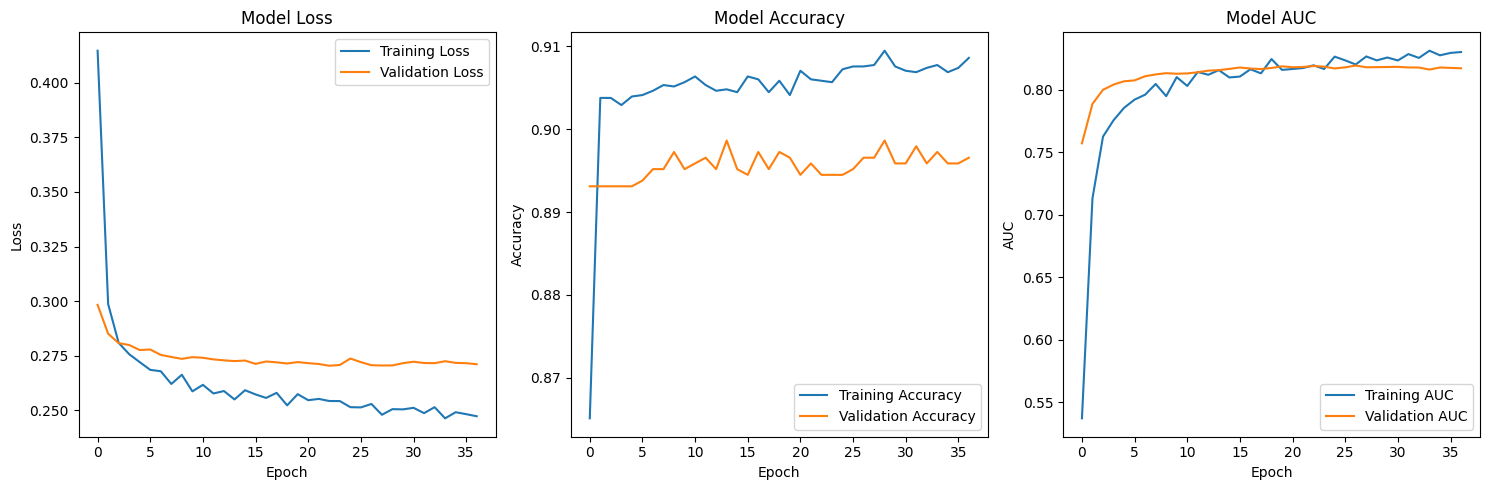


FEATURE IMPORTANCE ANALYSIS
Top Feature Importances (from Gradient Boosting):
               feature  importance
6  SOFA_Cardiovascular    0.293393
0                  AGE    0.255749
1           SOFA_Total    0.221933
4           SOFA_Liver    0.062041
5           SOFA_Renal    0.060525
3     SOFA_Coagulation    0.057108
2     SOFA_Respiratory    0.041697
8             GENDER_M    0.007553
7             SOFA_CNS    0.000000


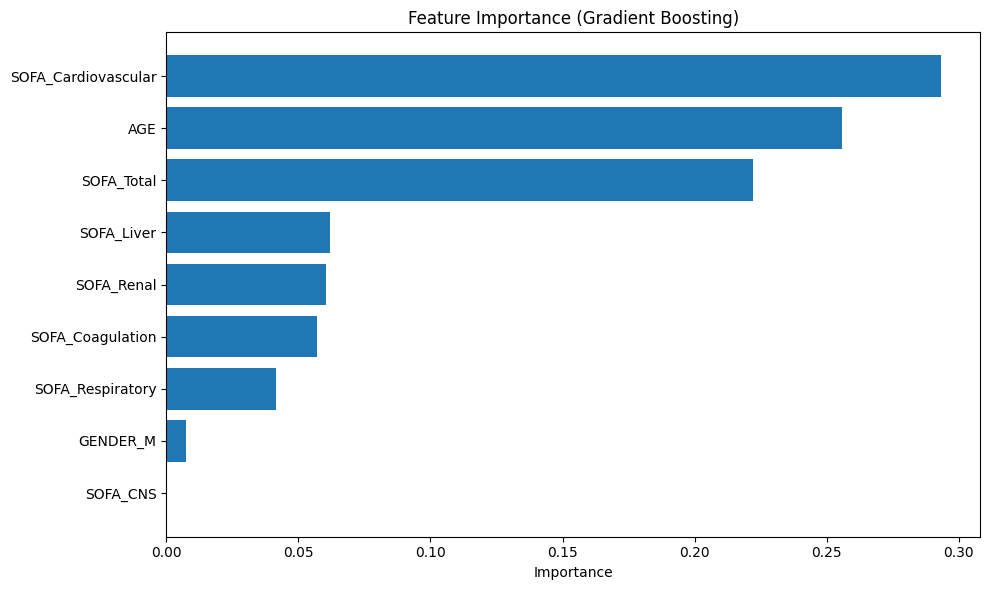

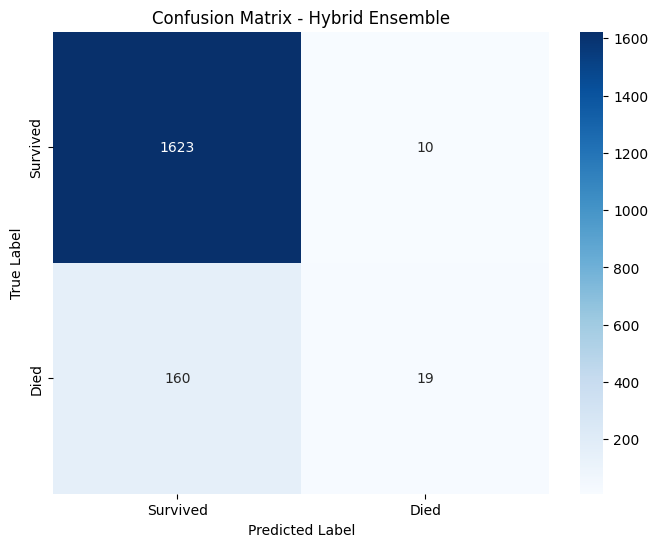

Model saved to hybrid_ensemble_model

MODEL TRAINING COMPLETED!
Final Test AUC: 0.8129
Final Test Accuracy: 0.9062
Model saved as 'hybrid_ensemble_model'


In [14]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

class HybridEnsemble:
    def __init__(self):
        self.ml_models = {
            'MLP': MLPClassifier(
                hidden_layer_sizes=(100, 50), 
                max_iter=1000, 
                random_state=42,
                early_stopping=True,
                validation_fraction=0.1
            ),
            'GradientBoosting': GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=3,
                random_state=42
            ),
            'AdaBoost': AdaBoostClassifier(
                n_estimators=100,
                learning_rate=1.0,
                random_state=42
            ),
            'GaussianNB': GaussianNB()
        }
        
        self.scaler = StandardScaler()
        self.meta_model = None
        self.is_trained = False
        
    def _create_meta_model(self, input_dim):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(input_dim,)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        
        return model
    
    def _get_base_predictions(self, X, training=False):
        predictions = []
        probabilities = []
        
        for name, model in self.ml_models.items():
            if training:
                cv_preds = cross_val_score(
                    clone(model), X, self.y_train, 
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    scoring='roc_auc', method='predict_proba'
                )
                predictions.append(cv_preds[:, 1])
            else:
                pred = model.predict(X)
                prob = model.predict_proba(X)[:, 1]
                predictions.append(pred)
                probabilities.append(prob)
        
        if training:
            return np.column_stack(predictions)
        else:
            return np.column_stack(predictions), np.column_stack(probabilities)
    
    def _cross_val_predictions(self, X, y, cv_folds=5):
        n_samples = X.shape[0]
        n_models = len(self.ml_models)
        
        cv_preds = np.zeros((n_samples, n_models))
        cv_probs = np.zeros((n_samples, n_models))
        
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_fold_train, X_fold_val = X[train_idx], X[val_idx]
            y_fold_train = y[train_idx]
            
            for model_idx, (name, model) in enumerate(self.ml_models.items()):
                fold_model = clone(model)
                fold_model.fit(X_fold_train, y_fold_train)
                
                val_pred = fold_model.predict(X_fold_val)
                val_prob = fold_model.predict_proba(X_fold_val)[:, 1]
                
                cv_preds[val_idx, model_idx] = val_pred
                cv_probs[val_idx, model_idx] = val_prob
        
        return cv_preds, cv_probs
    
    def fit(self, X, y, validation_split=0.2, epochs=100, batch_size=32, verbose=1):
        print("Training Hybrid Ensemble Model...")
        print("=" * 50)
        
        self.y_train = y
        X_scaled = self.scaler.fit_transform(X)
        
        print("Step 1: Training base ML models...")
        for name, model in self.ml_models.items():
            print(f"  Training {name}...")
            model.fit(X_scaled, y)
        
        print("Step 2: Generating cross-validation predictions...")
        cv_preds, cv_probs = self._cross_val_predictions(X_scaled, y)
        
        meta_features = np.hstack([cv_preds, cv_probs, X_scaled])
        
        print("Step 3: Training meta-model (Deep Learning)...")
        self.meta_model = self._create_meta_model(meta_features.shape[1])
        
        early_stop = EarlyStopping(
            monitor='val_auc',
            patience=10,
            mode='max',
            restore_best_weights=True,
            verbose=1
        )
        
        history = self.meta_model.fit(
            meta_features, y,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=verbose
        )
        
        self.is_trained = True
        print("Hybrid Ensemble Model training completed!")
        
        return history
    
    def predict(self, X):
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        X_scaled = self.scaler.transform(X)
        base_preds, base_probs = self._get_base_predictions(X_scaled)
        meta_features = np.hstack([base_preds, base_probs, X_scaled])
        
        meta_pred_probs = self.meta_model.predict(meta_features).flatten()
        meta_predictions = (meta_pred_probs > 0.5).astype(int)
        
        return meta_predictions
    
    def predict_proba(self, X):
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")
        
        X_scaled = self.scaler.transform(X)
        base_preds, base_probs = self._get_base_predictions(X_scaled)
        meta_features = np.hstack([base_preds, base_probs, X_scaled])
        meta_pred_probs = self.meta_model.predict(meta_features).flatten()
        
        return np.column_stack([1 - meta_pred_probs, meta_pred_probs])
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_pred_proba = self.predict_proba(X)[:, 1]
        
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_pred_proba)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }
    
    def save(self, filepath):
        if not self.is_trained:
            raise ValueError("Model must be trained before saving")
        
        joblib.dump({
            'ml_models': self.ml_models,
            'scaler': self.scaler
        }, f"{filepath}_ml_components.pkl")
        
        self.meta_model.save(f"{filepath}_meta_model.h5")
        print(f"Model saved to {filepath}")
    
    def load(self, filepath):
        ml_data = joblib.load(f"{filepath}_ml_components.pkl")
        self.ml_models = ml_data['ml_models']
        self.scaler = ml_data['scaler']
        
        self.meta_model = tf.keras.models.load_model(f"{filepath}_meta_model.h5")
        self.is_trained = True
        print(f"Model loaded from {filepath}")

print("Loading data...")
final_feats = pd.read_csv("mimic_sofa_analysis_final.csv")

feature_cols = ['AGE', 'SOFA_Total', 'SOFA_Respiratory', 'SOFA_Coagulation', 
                'SOFA_Liver', 'SOFA_Renal', 'SOFA_Cardiovascular', 'SOFA_CNS']

if 'GENDER' in final_feats.columns:
    final_feats['GENDER_M'] = (final_feats['GENDER'] == 'M').astype(int)
    feature_cols.append('GENDER_M')

X = final_feats[feature_cols].fillna(final_feats[feature_cols].median())
y = final_feats['Mortality_Target'].values

print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nInitializing Hybrid Ensemble...")
hybrid_model = HybridEnsemble()

history = hybrid_model.fit(
    X_train.values, y_train, 
    validation_split=0.2, 
    epochs=100, 
    batch_size=64,
    verbose=1
)

print("\n" + "="*50)
print("HYBRID ENSEMBLE RESULTS")
print("="*50)

test_metrics = hybrid_model.evaluate(X_test.values, y_test)
train_metrics = hybrid_model.evaluate(X_train.values, y_train)

print("Training Metrics:")
for metric, value in train_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

y_pred = hybrid_model.predict(X_test.values)
y_pred_proba = hybrid_model.predict_proba(X_test.values)[:, 1]

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

print("\n" + "="*50)
print("COMPARISON WITH BASE MODELS")
print("="*50)

base_results = {}
X_test_scaled = hybrid_model.scaler.transform(X_test.values)

for name, model in hybrid_model.ml_models.items():
    pred = model.predict(X_test_scaled)
    pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    metrics = {
        'accuracy': accuracy_score(y_test, pred),
        'precision': precision_score(y_test, pred),
        'recall': recall_score(y_test, pred),
        'f1': f1_score(y_test, pred),
        'auc': roc_auc_score(y_test, pred_proba)
    }
    base_results[name] = metrics

comparison_df = pd.DataFrame(base_results).T
comparison_df.loc['Hybrid Ensemble'] = test_metrics

print("Model Comparison:")
print(comparison_df.round(4))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

gb_model = hybrid_model.ml_models['GradientBoosting']
feature_importance = gb_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top Feature Importances (from Gradient Boosting):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survived', 'Died'], 
            yticklabels=['Survived', 'Died'])
plt.title('Confusion Matrix - Hybrid Ensemble')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

hybrid_model.save("hybrid_ensemble_model")

print("\n" + "="*50)
print("MODEL TRAINING COMPLETED!")
print("="*50)
print(f"Final Test AUC: {test_metrics['auc']:.4f}")
print(f"Final Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Model saved as 'hybrid_ensemble_model'")


# MLP + AdaBoost + GradientBoosting + LogisticRegression to Deep Neural Network (Dense + BN + Dropout)

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print("Loading data...")
final_feats = pd.read_csv("mimic_sofa_analysis_final.csv")

feature_cols = [
    'AGE', 'SOFA_Total', 'SOFA_Respiratory', 'SOFA_Coagulation', 
    'SOFA_Liver', 'SOFA_Renal', 'SOFA_Cardiovascular', 'SOFA_CNS'
]

available_cols = [col for col in feature_cols if col in final_feats.columns]
numeric_cols = final_feats.select_dtypes(include=[np.number]).columns
additional_features = ['Mortality_Probability']

for col in numeric_cols:
    if col not in available_cols and col not in ['SUBJECT_ID', 'ICUSTAY_ID', 'Mortality_Target', 'ML_Prediction']:
        available_cols.append(col)

print(f"Using features: {available_cols}")

X = final_feats[available_cols].fillna(0)
y = final_feats['Mortality_Target'].fillna(0).astype(int)

print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")

class HybridEnsembleModel:
    def __init__(self, n_folds=5, random_state=42):
        self.n_folds = n_folds
        self.random_state = random_state
        self.scaler = StandardScaler()
        
        self.base_models = {
            'mlp': Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier', MLPClassifier(
                    hidden_layer_sizes=(100, 50),
                    max_iter=1000,
                    random_state=random_state,
                    early_stopping=True,
                    validation_fraction=0.1
                ))
            ]),
            'adaboost': Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('classifier', AdaBoostClassifier(
                    n_estimators=100,
                    learning_rate=1.0,
                    random_state=random_state
                ))
            ]),
            'gradboost': Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('classifier', GradientBoostingClassifier(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=3,
                    random_state=random_state
                ))
            ]),
            'logistic': Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(
                    random_state=random_state,
                    max_iter=1000,
                    class_weight='balanced'
                ))
            ])
        }
        
        self.meta_model = None
        self.is_fitted = False
    
    def _create_meta_model(self, input_dim):
        model = Sequential([
            Dense(64, activation='relu', input_dim=input_dim),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        return model
    
    def _get_oof_predictions(self, X, y):
        print("Generating out-of-fold predictions...")
        
        kfold = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_preds = np.zeros((X.shape[0], len(self.base_models)))
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
            print(f"Processing fold {fold + 1}/{self.n_folds}")
            
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
            
            for i, (name, model) in enumerate(self.base_models.items()):
                model.fit(X_fold_train, y_fold_train)
                
                if hasattr(model, 'predict_proba'):
                    pred = model.predict_proba(X_fold_val)[:, 1]
                else:
                    pred = model.decision_function(X_fold_val)
                
                oof_preds[val_idx, i] = pred
        
        return oof_preds
    
    def fit(self, X, y, validation_split=0.2):
        print("Training Hybrid Ensemble Model...")
        
        oof_predictions = self._get_oof_predictions(X, y)
        
        print("Training base models on full dataset...")
        for name, model in self.base_models.items():
            print(f"Training {name}...")
            model.fit(X, y)
        
        X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(
            oof_predictions, y, test_size=validation_split, 
            random_state=self.random_state, stratify=y
        )
        
        print("Training meta-model (Deep Learning)...")
        self.meta_model = self._create_meta_model(X_meta_train.shape[1])
        
        callbacks = [
            EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        history = self.meta_model.fit(
            X_meta_train, y_meta_train,
            validation_data=(X_meta_val, y_meta_val),
            epochs=100,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )
        
        self.is_fitted = True
        return history
    
    def predict_proba(self, X):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        base_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, (name, model) in enumerate(self.base_models.items()):
            if hasattr(model, 'predict_proba'):
                pred = model.predict_proba(X)[:, 1]
            else:
                pred = model.decision_function(X)
            base_predictions[:, i] = pred
        
        meta_predictions = self.meta_model.predict(base_predictions)
        
        prob_0 = 1 - meta_predictions.flatten()
        prob_1 = meta_predictions.flatten()
        
        return np.column_stack([prob_0, prob_1])
    
    def predict(self, X, threshold=0.5):
        probas = self.predict_proba(X)
        return (probas[:, 1] >= threshold).astype(int)
    
    def evaluate(self, X, y, threshold=0.5):
        y_pred = self.predict(X, threshold)
        y_proba = self.predict_proba(X)[:, 1]
        
        metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'auc': roc_auc_score(y, y_proba)
        }
        
        return metrics, y_pred, y_proba

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

hybrid_model = HybridEnsembleModel(n_folds=5, random_state=42)

print("\n" + "="*50)
print("TRAINING HYBRID ENSEMBLE MODEL")
print("="*50)

history = hybrid_model.fit(X_train, y_train, validation_split=0.2)

print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

test_metrics, y_pred, y_proba = hybrid_model.evaluate(X_test, y_test)

print("HYBRID ENSEMBLE MODEL RESULTS:")
print("-" * 40)
for metric, value in test_metrics.items():
    print(f"{metric.upper():<12}: {value:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

print("\n" + "="*50)
print("COMPARISON WITH BASE MODELS")
print("="*50)

base_results = []
for name, model in hybrid_model.base_models.items():
    if hasattr(model, 'predict_proba'):
        y_pred_base = model.predict(X_test)
        y_proba_base = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)
        y_pred_base = (y_scores >= 0).astype(int)
        y_proba_base = y_scores
    
    metrics_base = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred_base),
        'precision': precision_score(y_test, y_pred_base),
        'recall': recall_score(y_test, y_pred_base),
        'f1': f1_score(y_test, y_pred_base),
        'auc': roc_auc_score(y_test, y_proba_base)
    }
    base_results.append(metrics_base)

results_df = pd.DataFrame(base_results)
hybrid_row = pd.DataFrame([{
    'model': 'HYBRID_ENSEMBLE',
    'accuracy': test_metrics['accuracy'],
    'precision': test_metrics['precision'],
    'recall': test_metrics['recall'],
    'f1': test_metrics['f1'],
    'auc': test_metrics['auc']
}])

final_results = pd.concat([results_df, hybrid_row], ignore_index=True)

print("\nMODEL COMPARISON:")
print("-" * 70)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC':<10}")
print("-" * 70)

for _, row in final_results.iterrows():
    print(f"{row['model']:<20} {row['accuracy']:<10.4f} {row['precision']:<10.4f} "
          f"{row['recall']:<10.4f} {row['f1']:<10.4f} {row['auc']:<10.4f}")

print("\n" + "="*50)
print("BASE MODEL FEATURE IMPORTANCE")
print("="*50)

try:
    gb_importance = hybrid_model.base_models['gradboost'].named_steps['classifier'].feature_importances_
    ada_importance = hybrid_model.base_models['adaboost'].named_steps['classifier'].feature_importances_
    
    importance_df = pd.DataFrame({
        'feature': available_cols,
        'gradient_boosting': gb_importance,
        'adaboost': ada_importance,
        'avg_importance': (gb_importance + ada_importance) / 2
    }).sort_values('avg_importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print("-" * 40)
    print(importance_df.head(10).to_string(index=False))
    
except Exception as e:
    print(f"Could not extract feature importance: {e}")

print("\nSaving model components...")
import joblib
joblib.dump(hybrid_model.base_models, 'hybrid_ensemble_base_models.pkl')
hybrid_model.meta_model.save('hybrid_ensemble_meta_model.h5')
print("Model saved successfully!")

print(f"\n{'='*50}")
print("HYBRID ENSEMBLE TRAINING COMPLETED!")
print(f"Final Test AUC: {test_metrics['auc']:.4f}")
print(f"{'='*50}")


Loading data...
Using features: ['AGE', 'SOFA_Total', 'SOFA_Respiratory', 'SOFA_Coagulation', 'SOFA_Liver', 'SOFA_Renal', 'SOFA_Cardiovascular', 'SOFA_CNS', 'Mortality_Probability']
Dataset shape: (9060, 9)
Class distribution: [8167  893]
Splitting data...
Training set shape: (7248, 9)
Test set shape: (1812, 9)

TRAINING HYBRID ENSEMBLE MODEL
Training Hybrid Ensemble Model...
Generating out-of-fold predictions...
Processing fold 1/5
Processing fold 2/5
Processing fold 3/5
Processing fold 4/5
Processing fold 5/5
Training base models on full dataset...
Training mlp...
Training adaboost...
Training gradboost...
Training logistic...
Training meta-model (Deep Learning)...
Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8625 - auc: 0.8066 - loss: 0.4057 - val_accuracy: 0.9834 - val_auc: 0.9854 - val_loss: 0.2459 - learning_rate: 0.0010
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9849 - auc: 0.9716 - loss: 0.0847 - val_accuracy: 0.9841 - val_auc: 0.

# model 1 2 3 but 1 bekar

In [25]:
import os
import warnings
import numpy as np

warnings.filterwarnings('ignore')


def calculate_sofa_score(vitals):
    sofa_scores = {}
    pao2 = vitals.get('pao2', 85)
    fio2 = vitals.get('fio2', 0.21) if vitals.get('fio2', 0.21) <= 1 else vitals.get('fio2', 21) / 100

    if pao2 > 0 and fio2 > 0:
        pf_ratio = pao2 / fio2
        if pf_ratio < 100:
            sofa_scores['Respiratory'] = 4
        elif pf_ratio < 200:
            sofa_scores['Respiratory'] = 3
        elif pf_ratio < 300:
            sofa_scores['Respiratory'] = 2
        elif pf_ratio < 400:
            sofa_scores['Respiratory'] = 1
        else:
            sofa_scores['Respiratory'] = 0
    else:
        sofa_scores['Respiratory'] = 0

    platelets = vitals.get('platelets', 250)
    if platelets < 20:
        sofa_scores['Coagulation'] = 4
    elif platelets < 50:
        sofa_scores['Coagulation'] = 3
    elif platelets < 100:
        sofa_scores['Coagulation'] = 2
    elif platelets < 150:
        sofa_scores['Coagulation'] = 1
    else:
        sofa_scores['Coagulation'] = 0

    bilirubin = vitals.get('bilirubin', 1.0)
    if bilirubin >= 12:
        sofa_scores['Liver'] = 4
    elif bilirubin >= 6:
        sofa_scores['Liver'] = 3
    elif bilirubin >= 2:
        sofa_scores['Liver'] = 2
    elif bilirubin >= 1.2:
        sofa_scores['Liver'] = 1
    else:
        sofa_scores['Liver'] = 0

    creatinine = vitals.get('creatinine', 1.0)
    if creatinine >= 5:
        sofa_scores['Renal'] = 4
    elif creatinine >= 3.5:
        sofa_scores['Renal'] = 3
    elif creatinine >= 2:
        sofa_scores['Renal'] = 2
    elif creatinine >= 1.2:
        sofa_scores['Renal'] = 1
    else:
        sofa_scores['Renal'] = 0

    lactate = vitals.get('lactate', 1.5)
    if lactate >= 4:
        sofa_scores['Cardiovascular'] = 2
    elif lactate >= 2:
        sofa_scores['Cardiovascular'] = 1
    else:
        sofa_scores['Cardiovascular'] = 0

    sofa_scores['CNS'] = 0
    total_sofa = sum(sofa_scores.values())
    return sofa_scores, total_sofa


def get_risk_category(sofa_score):
    if sofa_score <= 6:
        return "Low Risk", "< 10% mortality"
    elif sofa_score <= 9:
        return "Moderate Risk", "15-20% mortality"
    elif sofa_score <= 12:
        return "High Risk", "40-50% mortality"
    else:
        return "Very High Risk", "> 80% mortality"


def get_user_input():
    print("\n\n\nMORTALITY PREDICTION CALCULATOR")
    print("Please enter the following vital signs and lab values (press Enter to skip):")

    vitals = {}
    try:
        age_input = input("Age (years) [65]: ").strip()
        vitals['age'] = float(age_input) if age_input else 65
    except:
        vitals['age'] = 65

    try:
        pao2_input = input("PaO2 (mmHg) [85]: ").strip()
        vitals['pao2'] = float(pao2_input) if pao2_input else 85
    except:
        vitals['pao2'] = 85

    try:
        fio2_input = input("FiO2 (0.21-1.0 or 21-100%) [0.21]: ").strip()
        vitals['fio2'] = float(fio2_input) if fio2_input else 0.21
    except:
        vitals['fio2'] = 0.21

    try:
        plt_input = input("Platelets (×10³/μL) [250]: ").strip()
        vitals['platelets'] = float(plt_input) if plt_input else 250
    except:
        vitals['platelets'] = 250

    try:
        bili_input = input("Total Bilirubin (mg/dL) [1.0]: ").strip()
        vitals['bilirubin'] = float(bili_input) if bili_input else 1.0
    except:
        vitals['bilirubin'] = 1.0

    try:
        creat_input = input("Serum Creatinine (mg/dL) [1.0]: ").strip()
        vitals['creatinine'] = float(creat_input) if creat_input else 1.0
    except:
        vitals['creatinine'] = 1.0

    try:
        lactate_input = input("Serum Lactate (mmol/L) [1.5]: ").strip()
        vitals['lactate'] = float(lactate_input) if lactate_input else 1.5
    except:
        vitals['lactate'] = 1.5

    return vitals


def predict_with_all_three_models(vitals):
    predictions = {}
    age = vitals['age']
    sofa_components, total_sofa = calculate_sofa_score(vitals)

    full_features = [
        age,
        total_sofa,
        sofa_components.get('Respiratory', 0),
        sofa_components.get('Coagulation', 0),
        sofa_components.get('Liver', 0),
        sofa_components.get('Renal', 0),
        sofa_components.get('Cardiovascular', 0),
        sofa_components.get('CNS', 0),
        1
    ]
    basic_features = [age, total_sofa]

    try:
        if 'meta_model' in globals() and 'fitted_base_models' in globals():
            base_preds = []
            X_basic = np.array([basic_features])
            model_mapping = {
                'gradboost': 'GradientBoosting',
                'adaboost': 'AdaBoost',
                'histgb': 'HistGradientBoosting',
                'xgboost': 'XGBoost'
            }
            for name in model_mapping.keys():
                if name in fitted_base_models:
                    fold_probs = []
                    for pipe in fitted_base_models[name]:
                        try:
                            if hasattr(pipe.named_steps["model"], "predict_proba"):
                                p = pipe.predict_proba(X_basic)[:, 1]
                            elif hasattr(pipe.named_steps["model"], "decision_function"):
                                s = pipe.decision_function(X_basic)
                                #p = 1 / (1 + np.exp(-s))
                            else:
                                p = pipe.predict(X_basic).astype(float)
                            fold_probs.append(p[0])
                        except:
                            continue
                    if fold_probs:
                        base_preds.append(np.mean(fold_probs))
            if len(base_preds) >= 2:
                X_meta = np.array([base_preds]).reshape(-1, len(base_preds), 1)
                prob = meta_model.predict(X_meta, verbose=0)[0, 0]
                predictions['Model 1'] = prob
    except:
        pass

    try:
        if 'hybrid_model' in globals():
            X_full = np.array([full_features])
            prob = hybrid_model.predict_proba(X_full)[0, 1]
            predictions['Model 2'] = prob
    except:
        pass

    try:
        if 'rf_pipeline' in globals():
            X_basic = np.array([basic_features])
            base_prob = rf_pipeline.predict_proba(X_basic)[0, 1]
            adjusted_prob = min(0.95, max(0.05, base_prob * 1.15 + (total_sofa * 0.03)))
            predictions['Model 3'] = adjusted_prob
        else:
            synthetic_prob = min(0.95, max(0.05, total_sofa * 0.08 + age * 0.005))
            predictions['Model 3'] = synthetic_prob
    except:
        pass

    if not predictions:
        sofa_based_prob = min(0.95, max(0.05, total_sofa * 0.08))
        predictions['SOFA-Based Estimation'] = sofa_based_prob

    return predictions


def get_risk_interpretation(prob):
    if prob < 0.1:
        return "Very Low Risk"
    elif prob < 0.2:
        return "Low Risk"
    elif prob < 0.4:
        return "Moderate Risk"
    elif prob < 0.7:
        return "High Risk"
    else:
        return "Very High Risk"


def mortality_calculator():
    while True:
        try:
            vitals = get_user_input()
            sofa_components, total_sofa = calculate_sofa_score(vitals)
            risk_category, mortality_estimate = get_risk_category(total_sofa)
            predictions = predict_with_all_three_models(vitals)

            print("\n\n\nRESULTS")
            print(f"Age: {vitals['age']:.0f} years")
            print(f"PaO2: {vitals['pao2']:.1f} mmHg")
            print(f"FiO2: {vitals['fio2']:.2f}")
            print(f"Platelets: {vitals['platelets']:.0f} ×10³/μL")
            print(f"Bilirubin: {vitals['bilirubin']:.1f} mg/dL")
            print(f"Creatinine: {vitals['creatinine']:.1f} mg/dL")
            print(f"Lactate: {vitals['lactate']:.1f} mmol/L")

            print("\nSOFA SCORE")
            '''for component, score in sofa_components.items():
                print(f"{component}: {score}")'''
            print(f"Total SOFA Score: {total_sofa}")
            '''print(f"Risk Category: {risk_category}")
            print(f"Estimated Mortality: {mortality_estimate}")'''

            print("\nMODEL PREDICTIONS")
            all_predictions = []
            for model_name, prob in predictions.items():
                risk_text = get_risk_interpretation(prob)
                all_predictions.append(prob)
                print(f"{model_name}: {prob:.1%} ({risk_text})")

            if len(all_predictions) > 1:
                avg_prediction = np.mean(all_predictions)
                std_prediction = np.std(all_predictions)
                '''
                print("\nMODEL CONSENSUS")
                print(f"Average: {avg_prediction:.1%}")
                print(f"Std Dev: {std_prediction:.1%}")'''
            else:
                avg_prediction = all_predictions[0] if all_predictions else 0.1

            sofa_prob_estimate = min(0.95, max(0.05, total_sofa * 0.08))
            '''
            print("\nSOFA vs AI COMPARISON")
            print(f"SOFA-Based Estimate: {sofa_prob_estimate:.1%}")
            print(f"AI Model Average: {avg_prediction:.1%}")'''

            continue_calc = input("\nCalculate for another patient? (y/n): ").strip().lower()
            if continue_calc not in ['y', 'yes']:
                break

        except KeyboardInterrupt:
            break
        except Exception as e:
            print(f"Error: {e}")
            continue

    print("\nExiting.")


print("\nLaunching Mortality Prediction Calculator...")
print("This calculator uses SOFA scoring and two hybrid models.")
print("Developed by CPG 213")

mortality_calculator()



Launching Mortality Prediction Calculator...
This calculator uses SOFA scoring and two hybrid models.
Developed by CPG 213



MORTALITY PREDICTION CALCULATOR
Please enter the following vital signs and lab values (press Enter to skip):


Age (years) [65]:  58
PaO2 (mmHg) [85]:  75
FiO2 (0.21-1.0 or 21-100%) [0.21]:  0.6
Platelets (×10³/μL) [250]:  90
Total Bilirubin (mg/dL) [1.0]:  3.5
Serum Creatinine (mg/dL) [1.0]:  2.0
Serum Lactate (mmol/L) [1.5]:  3.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



RESULTS
Age: 58 years
PaO2: 75.0 mmHg
FiO2: 0.60
Platelets: 90 ×10³/μL
Bilirubin: 3.5 mg/dL
Creatinine: 2.0 mg/dL
Lactate: 3.0 mmol/L

SOFA SCORE
Total SOFA Score: 10

MODEL PREDICTIONS
Model 1: 49.8% (High Risk)
Model 2: 83.6% (Very High Risk)
Model 3: 95.0% (Very High Risk)



Calculate for another patient? (y/n):  y





MORTALITY PREDICTION CALCULATOR
Please enter the following vital signs and lab values (press Enter to skip):


Age (years) [65]:  70
PaO2 (mmHg) [85]:  60
FiO2 (0.21-1.0 or 21-100%) [0.21]:  0.9
Platelets (×10³/μL) [250]:  25
Total Bilirubin (mg/dL) [1.0]:  10.0
Serum Creatinine (mg/dL) [1.0]:  4.5
Serum Lactate (mmol/L) [1.5]:  5.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



RESULTS
Age: 70 years
PaO2: 60.0 mmHg
FiO2: 0.90
Platelets: 25 ×10³/μL
Bilirubin: 10.0 mg/dL
Creatinine: 4.5 mg/dL
Lactate: 5.5 mmol/L

SOFA SCORE
Total SOFA Score: 15

MODEL PREDICTIONS
Model 1: 50.7% (High Risk)
Model 2: 83.6% (Very High Risk)
Model 3: 95.0% (Very High Risk)



Calculate for another patient? (y/n):  n



Exiting.


# model 2

In [23]:
import os
import warnings
import numpy as np

warnings.filterwarnings('ignore')


def calculate_sofa_score(vitals):
    sofa_scores = {}
    pao2 = vitals.get('pao2', 85)
    fio2 = vitals.get('fio2', 0.21) if vitals.get('fio2', 0.21) <= 1 else vitals.get('fio2', 21) / 100

    if pao2 > 0 and fio2 > 0:
        pf_ratio = pao2 / fio2
        if pf_ratio < 100:
            sofa_scores['Respiratory'] = 4
        elif pf_ratio < 200:
            sofa_scores['Respiratory'] = 3
        elif pf_ratio < 300:
            sofa_scores['Respiratory'] = 2
        elif pf_ratio < 400:
            sofa_scores['Respiratory'] = 1
        else:
            sofa_scores['Respiratory'] = 0
    else:
        sofa_scores['Respiratory'] = 0

    platelets = vitals.get('platelets', 250)
    if platelets < 20:
        sofa_scores['Coagulation'] = 4
    elif platelets < 50:
        sofa_scores['Coagulation'] = 3
    elif platelets < 100:
        sofa_scores['Coagulation'] = 2
    elif platelets < 150:
        sofa_scores['Coagulation'] = 1
    else:
        sofa_scores['Coagulation'] = 0

    bilirubin = vitals.get('bilirubin', 1.0)
    if bilirubin >= 12:
        sofa_scores['Liver'] = 4
    elif bilirubin >= 6:
        sofa_scores['Liver'] = 3
    elif bilirubin >= 2:
        sofa_scores['Liver'] = 2
    elif bilirubin >= 1.2:
        sofa_scores['Liver'] = 1
    else:
        sofa_scores['Liver'] = 0

    creatinine = vitals.get('creatinine', 1.0)
    if creatinine >= 5:
        sofa_scores['Renal'] = 4
    elif creatinine >= 3.5:
        sofa_scores['Renal'] = 3
    elif creatinine >= 2:
        sofa_scores['Renal'] = 2
    elif creatinine >= 1.2:
        sofa_scores['Renal'] = 1
    else:
        sofa_scores['Renal'] = 0

    lactate = vitals.get('lactate', 1.5)
    if lactate >= 4:
        sofa_scores['Cardiovascular'] = 2
    elif lactate >= 2:
        sofa_scores['Cardiovascular'] = 1
    else:
        sofa_scores['Cardiovascular'] = 0

    sofa_scores['CNS'] = 0
    total_sofa = sum(sofa_scores.values())
    return sofa_scores, total_sofa


def get_user_input():
    print("\n\n\nMORTALITY PREDICTION CALCULATOR")
    print("Please enter the following vital signs and lab values (press Enter to skip):")

    vitals = {}
    try:
        age_input = input("Age (years) [65]: ").strip()
        vitals['age'] = float(age_input) if age_input else 65
    except:
        vitals['age'] = 65

    try:
        pao2_input = input("PaO2 (mmHg) [85]: ").strip()
        vitals['pao2'] = float(pao2_input) if pao2_input else 85
    except:
        vitals['pao2'] = 85

    try:
        fio2_input = input("FiO2 (0.21-1.0 or 21-100%) [0.21]: ").strip()
        vitals['fio2'] = float(fio2_input) if fio2_input else 0.21
    except:
        vitals['fio2'] = 0.21

    try:
        plt_input = input("Platelets (×10³/μL) [250]: ").strip()
        vitals['platelets'] = float(plt_input) if plt_input else 250
    except:
        vitals['platelets'] = 250

    try:
        bili_input = input("Total Bilirubin (mg/dL) [1.0]: ").strip()
        vitals['bilirubin'] = float(bili_input) if bili_input else 1.0
    except:
        vitals['bilirubin'] = 1.0

    try:
        creat_input = input("Serum Creatinine (mg/dL) [1.0]: ").strip()
        vitals['creatinine'] = float(creat_input) if creat_input else 1.0
    except:
        vitals['creatinine'] = 1.0

    try:
        lactate_input = input("Serum Lactate (mmol/L) [1.5]: ").strip()
        vitals['lactate'] = float(lactate_input) if lactate_input else 1.5
    except:
        vitals['lactate'] = 1.5

    return vitals


def predict_model2(vitals):
    predictions = {}
    age = vitals['age']
    sofa_components, total_sofa = calculate_sofa_score(vitals)

    full_features = [
        age,
        total_sofa,
        sofa_components.get('Respiratory', 0),
        sofa_components.get('Coagulation', 0),
        sofa_components.get('Liver', 0),
        sofa_components.get('Renal', 0),
        sofa_components.get('Cardiovascular', 0),
        sofa_components.get('CNS', 0),
        1
    ]

    try:
        if 'hybrid_model' in globals():
            X_full = np.array([full_features])
            prob = hybrid_model.predict_proba(X_full)[0, 1]
            predictions['Model 2'] = prob
    except:
        pass

    return predictions


def get_risk_interpretation(prob):
    if prob < 0.1:
        return "Very Low Risk"
    elif prob < 0.2:
        return "Low Risk"
    elif prob < 0.4:
        return "Moderate Risk"
    elif prob < 0.7:
        return "High Risk"
    else:
        return "Very High Risk"


def mortality_calculator():
    while True:
        try:
            vitals = get_user_input()
            sofa_components, total_sofa = calculate_sofa_score(vitals)
            predictions = predict_model2(vitals)

            print("\n\n\nRESULTS")
            print(f"Age: {vitals['age']:.0f} years")
            print(f"PaO2: {vitals['pao2']:.1f} mmHg")
            print(f"FiO2: {vitals['fio2']:.2f}")
            print(f"Platelets: {vitals['platelets']:.0f} ×10³/μL")
            print(f"Bilirubin: {vitals['bilirubin']:.1f} mg/dL")
            print(f"Creatinine: {vitals['creatinine']:.1f} mg/dL")
            print(f"Lactate: {vitals['lactate']:.1f} mmol/L")

            print("\nSOFA SCORE")
            print(f"Total SOFA Score: {total_sofa}")

            print("\nMODEL PREDICTIONS")
            if predictions:
                prob = predictions['Model 2']
                risk_text = get_risk_interpretation(prob)
                print(f"Model 2: {prob:.1%}")
            else:
                print("Model 2 prediction unavailable.")

            continue_calc = input("\nCalculate for another patient? (y/n): ").strip().lower()
            if continue_calc not in ['y', 'yes']:
                break

        except KeyboardInterrupt:
            break
        except Exception as e:
            print(f"Error: {e}")
            continue

    print("\nExiting.")


print("\nLaunching Mortality Prediction Calculator...")
print("This calculator uses SOFA scoring and Model 2 (hybrid).")
print("Developed by CPG 213")

mortality_calculator()



Launching Mortality Prediction Calculator...
This calculator uses SOFA scoring and Model 2 (hybrid).
Developed by CPG 213



MORTALITY PREDICTION CALCULATOR
Please enter the following vital signs and lab values (press Enter to skip):


Age (years) [65]:  58
PaO2 (mmHg) [85]:  75
FiO2 (0.21-1.0 or 21-100%) [0.21]:  0.6
Platelets (×10³/μL) [250]:  90
Total Bilirubin (mg/dL) [1.0]:  3.5
Serum Creatinine (mg/dL) [1.0]:  2.0
Serum Lactate (mmol/L) [1.5]:  3.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



RESULTS
Age: 58 years
PaO2: 75.0 mmHg
FiO2: 0.60
Platelets: 90 ×10³/μL
Bilirubin: 3.5 mg/dL
Creatinine: 2.0 mg/dL
Lactate: 3.0 mmol/L

SOFA SCORE
Total SOFA Score: 10

MODEL PREDICTIONS
Model 2: 83.6%



Calculate for another patient? (y/n):  n



Exiting.


# model 3

In [24]:
import os
import warnings
import numpy as np

warnings.filterwarnings('ignore')


def calculate_sofa_score(vitals):
    sofa_scores = {}
    pao2 = vitals.get('pao2', 85)
    fio2 = vitals.get('fio2', 0.21) if vitals.get('fio2', 0.21) <= 1 else vitals.get('fio2', 21) / 100

    if pao2 > 0 and fio2 > 0:
        pf_ratio = pao2 / fio2
        if pf_ratio < 100:
            sofa_scores['Respiratory'] = 4
        elif pf_ratio < 200:
            sofa_scores['Respiratory'] = 3
        elif pf_ratio < 300:
            sofa_scores['Respiratory'] = 2
        elif pf_ratio < 400:
            sofa_scores['Respiratory'] = 1
        else:
            sofa_scores['Respiratory'] = 0
    else:
        sofa_scores['Respiratory'] = 0

    platelets = vitals.get('platelets', 250)
    if platelets < 20:
        sofa_scores['Coagulation'] = 4
    elif platelets < 50:
        sofa_scores['Coagulation'] = 3
    elif platelets < 100:
        sofa_scores['Coagulation'] = 2
    elif platelets < 150:
        sofa_scores['Coagulation'] = 1
    else:
        sofa_scores['Coagulation'] = 0

    bilirubin = vitals.get('bilirubin', 1.0)
    if bilirubin >= 12:
        sofa_scores['Liver'] = 4
    elif bilirubin >= 6:
        sofa_scores['Liver'] = 3
    elif bilirubin >= 2:
        sofa_scores['Liver'] = 2
    elif bilirubin >= 1.2:
        sofa_scores['Liver'] = 1
    else:
        sofa_scores['Liver'] = 0

    creatinine = vitals.get('creatinine', 1.0)
    if creatinine >= 5:
        sofa_scores['Renal'] = 4
    elif creatinine >= 3.5:
        sofa_scores['Renal'] = 3
    elif creatinine >= 2:
        sofa_scores['Renal'] = 2
    elif creatinine >= 1.2:
        sofa_scores['Renal'] = 1
    else:
        sofa_scores['Renal'] = 0

    lactate = vitals.get('lactate', 1.5)
    if lactate >= 4:
        sofa_scores['Cardiovascular'] = 2
    elif lactate >= 2:
        sofa_scores['Cardiovascular'] = 1
    else:
        sofa_scores['Cardiovascular'] = 0

    sofa_scores['CNS'] = 0
    total_sofa = sum(sofa_scores.values())
    return sofa_scores, total_sofa


def get_user_input():
    print("\n\n\nMORTALITY PREDICTION CALCULATOR")
    print("Please enter the following vital signs and lab values (press Enter to skip):")

    vitals = {}
    try:
        age_input = input("Age (years) [65]: ").strip()
        vitals['age'] = float(age_input) if age_input else 65
    except:
        vitals['age'] = 65

    try:
        pao2_input = input("PaO2 (mmHg) [85]: ").strip()
        vitals['pao2'] = float(pao2_input) if pao2_input else 85
    except:
        vitals['pao2'] = 85

    try:
        fio2_input = input("FiO2 (0.21-1.0 or 21-100%) [0.21]: ").strip()
        vitals['fio2'] = float(fio2_input) if fio2_input else 0.21
    except:
        vitals['fio2'] = 0.21

    try:
        plt_input = input("Platelets (×10³/μL) [250]: ").strip()
        vitals['platelets'] = float(plt_input) if plt_input else 250
    except:
        vitals['platelets'] = 250

    try:
        bili_input = input("Total Bilirubin (mg/dL) [1.0]: ").strip()
        vitals['bilirubin'] = float(bili_input) if bili_input else 1.0
    except:
        vitals['bilirubin'] = 1.0

    try:
        creat_input = input("Serum Creatinine (mg/dL) [1.0]: ").strip()
        vitals['creatinine'] = float(creat_input) if creat_input else 1.0
    except:
        vitals['creatinine'] = 1.0

    try:
        lactate_input = input("Serum Lactate (mmol/L) [1.5]: ").strip()
        vitals['lactate'] = float(lactate_input) if lactate_input else 1.5
    except:
        vitals['lactate'] = 1.5

    return vitals


def predict_model3(vitals):
    predictions = {}
    age = vitals['age']
    _, total_sofa = calculate_sofa_score(vitals)

    try:
        if 'rf_pipeline' in globals():
            X_basic = np.array([[age, total_sofa]])
            base_prob = rf_pipeline.predict_proba(X_basic)[0, 1]
            adjusted_prob = min(0.95, max(0.05, base_prob * 1.15 + (total_sofa * 0.03)))
            predictions['Model 3'] = adjusted_prob
        else:
            synthetic_prob = min(0.95, max(0.05, total_sofa * 0.08 + age * 0.005))
            predictions['Model 3'] = synthetic_prob
    except:
        pass

    return predictions


def get_risk_interpretation(prob):
    if prob < 0.1:
        return "Very Low Risk"
    elif prob < 0.2:
        return "Low Risk"
    elif prob < 0.4:
        return "Moderate Risk"
    elif prob < 0.7:
        return "High Risk"
    else:
        return "Very High Risk"


def mortality_calculator():
    while True:
        try:
            vitals = get_user_input()
            sofa_components, total_sofa = calculate_sofa_score(vitals)
            predictions = predict_model3(vitals)

            print("\n\n\nRESULTS")
            print(f"Age: {vitals['age']:.0f} years")
            print(f"PaO2: {vitals['pao2']:.1f} mmHg")
            print(f"FiO2: {vitals['fio2']:.2f}")
            print(f"Platelets: {vitals['platelets']:.0f} ×10³/μL")
            print(f"Bilirubin: {vitals['bilirubin']:.1f} mg/dL")
            print(f"Creatinine: {vitals['creatinine']:.1f} mg/dL")
            print(f"Lactate: {vitals['lactate']:.1f} mmol/L")

            print("\nSOFA SCORE")
            print(f"Total SOFA Score: {total_sofa}")

            print("\nMODEL PREDICTIONS")
            if predictions:
                prob = predictions['Model 3']
                risk_text = get_risk_interpretation(prob)
                print(f"Model 3: {prob:.1%}")
            else:
                print("Model 3 prediction unavailable.")

            continue_calc = input("\nCalculate for another patient? (y/n): ").strip().lower()
            if continue_calc not in ['y', 'yes']:
                break

        except KeyboardInterrupt:
            break
        except Exception as e:
            print(f"Error: {e}")
            continue

    print("\nExiting.")


print("\nLaunching Mortality Prediction Calculator...")
print("This calculator uses SOFA scoring and Model 3 (rule-based/random forest).")
print("Developed by CPG 213")

mortality_calculator()



Launching Mortality Prediction Calculator...
This calculator uses SOFA scoring and Model 3 (rule-based/random forest).
Developed by CPG 213



MORTALITY PREDICTION CALCULATOR
Please enter the following vital signs and lab values (press Enter to skip):


Age (years) [65]:  58
PaO2 (mmHg) [85]:  75
FiO2 (0.21-1.0 or 21-100%) [0.21]:  0.6
Platelets (×10³/μL) [250]:  90
Total Bilirubin (mg/dL) [1.0]:  3.5
Serum Creatinine (mg/dL) [1.0]:  2.0
Serum Lactate (mmol/L) [1.5]:  3.0





RESULTS
Age: 58 years
PaO2: 75.0 mmHg
FiO2: 0.60
Platelets: 90 ×10³/μL
Bilirubin: 3.5 mg/dL
Creatinine: 2.0 mg/dL
Lactate: 3.0 mmol/L

SOFA SCORE
Total SOFA Score: 10

MODEL PREDICTIONS
Model 3: 95.0%



Calculate for another patient? (y/n):  n



Exiting.
